In [3]:
import numpy as np
import glob 
import matplotlib.pyplot as plt

In [ ]:
def load_activation_frequencies():
    """
    Load activation frequencies from files.
    
    Returns:
        tuple: (addition_freq, subtraction_freq, random_addition_freq, random_subtraction_freq)
    """
    # Load regular activation frequencies
    addition_files = sorted(glob.glob(r'../../activ_freq/addition/layer_*.npy'))
    subtraction_files = sorted(glob.glob(r'../../activ_freq/subtraction/layer_*.npy'))
    
    addition_freq = np.array([np.load(f) for f in addition_files])
    subtraction_freq = np.array([np.load(f) for f in subtraction_files])
    
    # Load random activation frequencies
    random_addition_files = sorted(glob.glob(r'../../activ_freq/random_addition/layer_*.npy'))
    random_subtraction_files = sorted(glob.glob(r'../../activ_freq/random_subtraction/layer_*.npy'))
    
    random_addition_freq = np.array([np.load(f) for f in random_addition_files])
    random_subtraction_freq = np.array([np.load(f) for f in random_subtraction_files])
    
    return addition_freq, subtraction_freq, random_addition_freq, random_subtraction_freq


def calculate_feature_indices(addition_freq, subtraction_freq, random_addition_freq, random_subtraction_freq, 
                            upper_bound=0.7, lower_bound=0.2):
    """
    Calculate feature indices based on activation frequencies and thresholds.
    
    Args:
        addition_freq: Regular addition activation frequencies
        subtraction_freq: Regular subtraction activation frequencies
        random_addition_freq: Random addition activation frequencies
        random_subtraction_freq: Random subtraction activation frequencies
        upper_bound: Upper threshold for activation frequency
        lower_bound: Lower threshold for activation frequency
        
    Returns:
        tuple: (addition_indices, subtraction_indices)
    """
    addition_indices = []
    subtraction_indices = []

    for layer in range(addition_freq.shape[0]):
        # Regular frequencies
        add_layer = addition_freq[layer]
        sub_layer = subtraction_freq[layer]
        
        # Random frequencies
        random_add_layer = random_addition_freq[layer]
        random_sub_layer = random_subtraction_freq[layer]

        # Get indices for regular data using bounds
        regular_add_indices = set(np.where((add_layer > upper_bound) & (sub_layer < lower_bound))[0])
        regular_sub_indices = set(np.where((add_layer < lower_bound) & (sub_layer > upper_bound))[0])
        
        # Get indices for random data using bounds
        random_add_indices = set(np.where((random_add_layer > upper_bound) & (random_sub_layer < lower_bound))[0])
        random_sub_indices = set(np.where((random_add_layer < lower_bound) & (random_sub_layer > upper_bound))[0])
        
        # Take intersection of regular and random indices
        final_add_indices = list(regular_add_indices.intersection(random_add_indices))
        final_sub_indices = list(regular_sub_indices.intersection(random_sub_indices))

        addition_indices.append(final_add_indices)
        subtraction_indices.append(final_sub_indices)

    return addition_indices, subtraction_indices


# Example usage:
frequencies = load_activation_frequencies()
addition_freq, subtraction_freq, random_addition_freq, random_subtraction_freq = frequencies

addition_indices, subtraction_indices = calculate_feature_indices(
    addition_freq, subtraction_freq, random_addition_freq, random_subtraction_freq,
    upper_bound=0.6, lower_bound=0.3
)

def get_top_bottom_features(addition_freq, subtraction_freq, random_addition_freq, random_subtraction_freq, top_n=3):
    top_features = []
    bottom_features = []

    for layer in range(addition_freq.shape[0]):
        diff = (addition_freq[layer] - subtraction_freq[layer]) + (random_addition_freq[layer] - random_subtraction_freq[layer])
        sorted_indices = np.argsort(diff)

        top_indices = sorted_indices[-top_n:].tolist()
        bottom_indices = sorted_indices[:top_n].tolist()

        top_features.append(top_indices)
        bottom_features.append(bottom_indices)

    return top_features, bottom_features


add_features, sub_features = get_top_bottom_features(
    addition_freq, subtraction_freq, random_addition_freq, random_subtraction_freq, top_n=5)


In [2]:
for idx, inner_list in enumerate(addition_indices):
    print(inner_list.__len__(),end=' ')

1 0 3 5 5 5 9 7 10 5 5 4 7 6 4 6 4 1 0 3 2 3 2 3 8 2 

In [5]:
for idx, inner_list in enumerate(subtraction_indices):
    print(inner_list.__len__(),end=' ')

0 0 3 2 6 2 7 2 4 7 2 2 2 1 2 1 1 0 0 2 5 5 3 3 3 3 

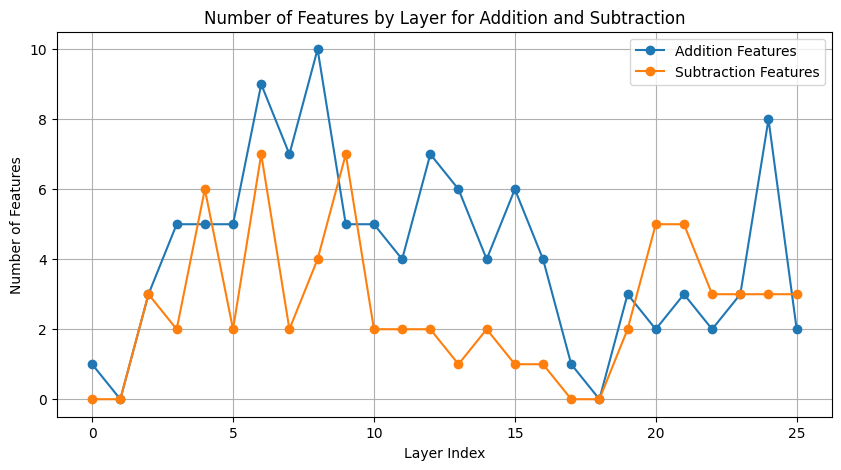

In [4]:
# line plot the number of features for each layer for subtraction and addition

def plot_feature_counts_by_layer(addition_indices, subtraction_indices):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(addition_indices)), [len(lst) for lst in addition_indices], label='Addition Features', marker='o')
    plt.plot(range(len(subtraction_indices)), [len(lst) for lst in subtraction_indices], label='Subtraction Features', marker='o')
    plt.xlabel('Layer Index')
    plt.ylabel('Number of Features')
    plt.title('Number of Features by Layer for Addition and Subtraction')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_feature_counts_by_layer(addition_indices, subtraction_indices)

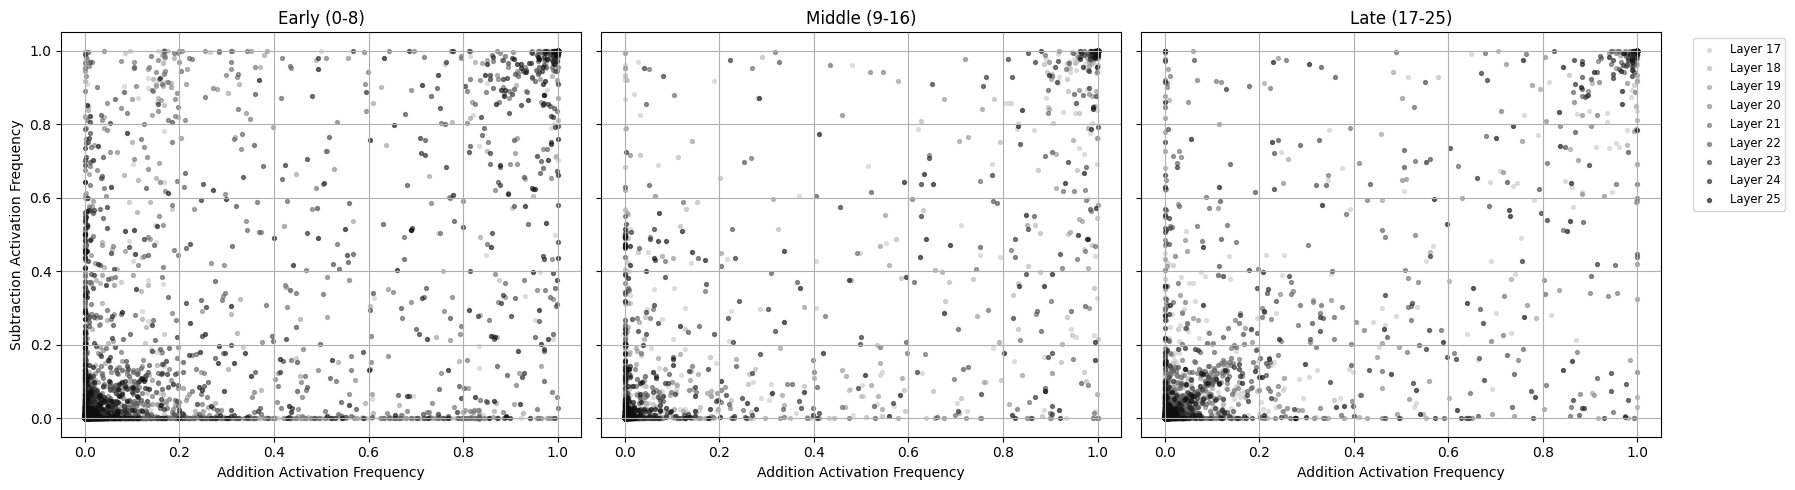

In [13]:
import matplotlib.cm as cm

def plot_activation_frequencies_by_stage(addition_freq, subtraction_freq):
    stages = {
        'Early (0-8)': (0, 9),
        'Middle (9-16)': (9, 17),
        'Late (17-25)': (17, 26)
    }
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for ax, (stage, (start, end)) in zip(axes, stages.items()):
        num_layers = end - start
        colors = cm.Greys(np.linspace(0.3, 0.95, num_layers))
        for i, layer in enumerate(range(start, end)):
            ax.scatter(
                addition_freq[layer], subtraction_freq[layer],
                color=colors[i], label=f'Layer {layer}', alpha=0.6, s=8
            )
        ax.set_title(stage)
        ax.set_xlabel('Addition Activation Frequency')
        if ax is axes[0]:
            ax.set_ylabel('Subtraction Activation Frequency')
        ax.grid(True)
        # Only show legend for the last subplot to avoid clutter
        if ax is axes[-1]:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    plt.tight_layout()
    plt.show()

plot_activation_frequencies_by_stage(addition_freq, subtraction_freq)

In [ ]:
# using activation frequencies, calculate the sum of (addition - subtraction) and (random_addition - random_subtraction) for each feature in each layer.
# return for each layer n features with highest and n features with lowest summed differences.
def get_top_bottom_features(addition_freq, subtraction_freq, random_addition_freq, random_subtraction_freq, top_n=3):
    top_features = []
    bottom_features = []

    for layer in range(addition_freq.shape[0]):
        diff = (addition_freq[layer] - subtraction_freq[layer]) + (random_addition_freq[layer] - random_subtraction_freq[layer])
        sorted_indices = np.argsort(diff)

        top_indices = sorted_indices[-top_n:].tolist()
        bottom_indices = sorted_indices[:top_n].tolist()

        top_features.append(top_indices)
        bottom_features.append(bottom_indices)

    return top_features, bottom_features


top_features, bottom_features = get_top_bottom_features(
    addition_freq, subtraction_freq, random_addition_freq, random_subtraction_freq, top_n=5)

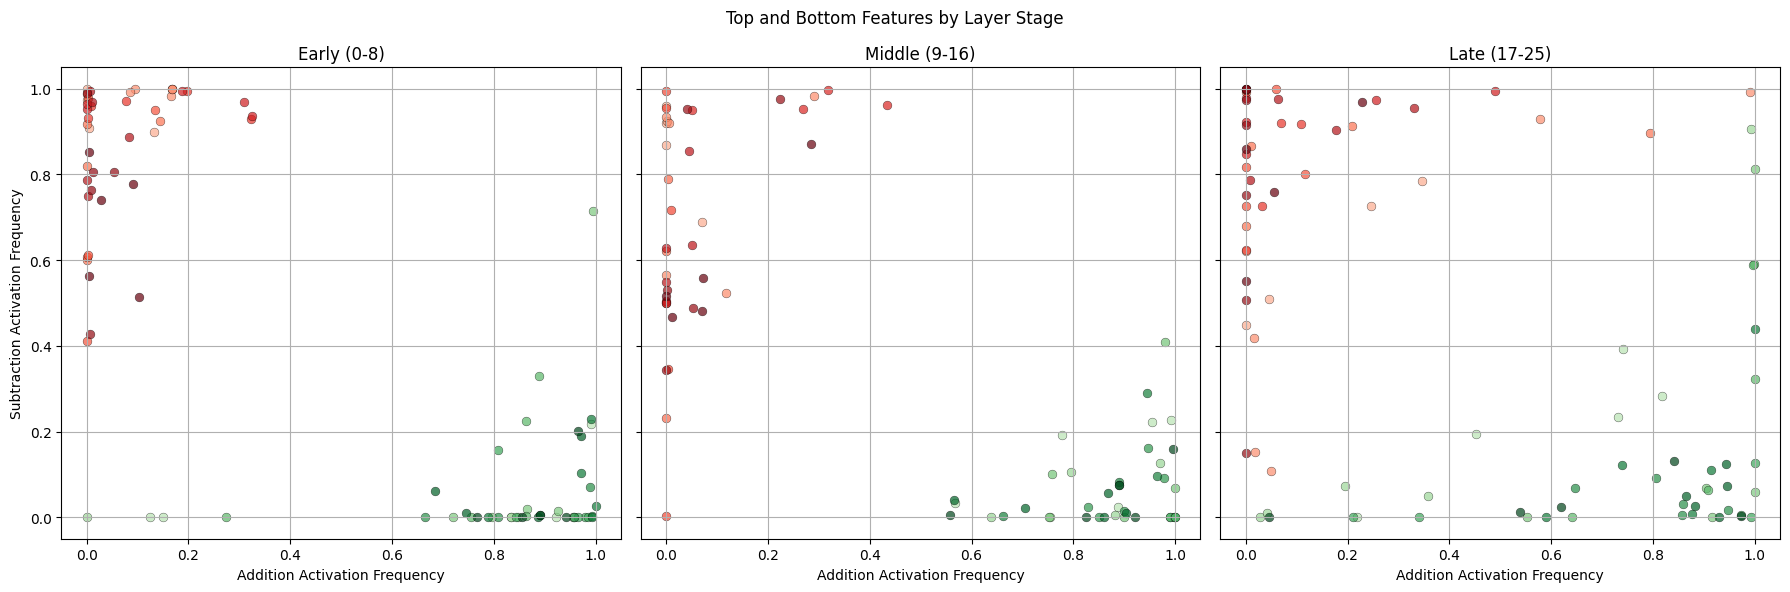

In [15]:
def plot_top_bottom_features_by_stage(addition_freq, subtraction_freq, top_features, bottom_features):
    import matplotlib.cm as cm

    stages = {
        'Early (0-8)': (0, 9),
        'Middle (9-16)': (9, 17),
        'Late (17-25)': (17, 26)
    }
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for ax, (stage, (start, end)) in zip(axes, stages.items()):
        num_layers = end - start
        colors = cm.Greys(np.linspace(0.3, 0.95, num_layers))
        for i, layer in enumerate(range(start, end)):
            # Top features: green, darker for later layers
            ax.scatter(
                addition_freq[layer][top_features[layer]],
                subtraction_freq[layer][top_features[layer]],
                color=cm.Greens(0.3 + 0.7 * i / (num_layers-1)) if num_layers > 1 else cm.Greens(0.95),
                label=f'Layer {layer} Top' if i == 0 else None,
                alpha=0.7, s=40, edgecolor='k', linewidth=0.3
            )
            # Bottom features: red, darker for later layers
            ax.scatter(
                addition_freq[layer][bottom_features[layer]],
                subtraction_freq[layer][bottom_features[layer]],
                color=cm.Reds(0.3 + 0.7 * i / (num_layers-1)) if num_layers > 1 else cm.Reds(0.95),
                label=f'Layer {layer} Bottom' if i == 0 else None,
                alpha=0.7, s=40, edgecolor='k', linewidth=0.3
            )
        ax.set_title(stage)
        ax.set_xlabel('Addition Activation Frequency')
        ax.grid(True)
    axes[0].set_ylabel('Subtraction Activation Frequency')
    plt.suptitle('Top and Bottom Features by Layer Stage')
    plt.tight_layout()
    plt.show()

top_features, bottom_features = get_top_bottom_features(
    addition_freq, subtraction_freq, random_addition_freq, random_subtraction_freq, top_n=5)
plot_top_bottom_features_by_stage(addition_freq, subtraction_freq, top_features, bottom_features)

## TO-DO: plot a bar chart that shows for each feature how much it activates for low and high ranges (grouped bar chart).

In [16]:
# Load SAEs for all layers and extract decoder vectors for top_features and bottom_features in a memory-efficient way

import torch
from sae_lens import SAE
import torch.nn.functional as F
import gc

torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"

decoder_vectors = []
for layer in range(26):
    sae_id = f"layer_{layer}/width_16k/canonical"
    sae, _, _ = SAE.from_pretrained(
        release="gemma-scope-2b-pt-res-canonical",
        sae_id=sae_id
    )
    sae = sae.to(device)
    sae.eval()
    W_dec = sae.W_dec.to(device)  # shape: [16384, 2304]
    W_dec_normalized = F.normalize(W_dec, p=2, dim=1)
    decoder_vectors.append(W_dec_normalized.cpu().numpy())
    # Free up GPU memory
    del sae, W_dec, W_dec_normalized
    torch.cuda.empty_cache()
    gc.collect()

decoder_vectors = np.array(decoder_vectors)  # shape: [24, 16384, 2304]


In [17]:
def get_decoder_vectors(top_features, bottom_features, decoder_vectors):
    top_features_decoders = []
    bottom_features_decoders = []
    for layer in range(len(top_features)):
        top_vectors = decoder_vectors[layer][top_features[layer]]
        bottom_vectors = decoder_vectors[layer][bottom_features[layer]]
        top_features_decoders.append(top_vectors)
        bottom_features_decoders.append(bottom_vectors)
    return np.array(top_features_decoders), np.array(bottom_features_decoders)

top_features_decoders, bottom_features_decoders = get_decoder_vectors(top_features, bottom_features, decoder_vectors)

gc.collect()

7

In [18]:
top_features_decoders.shape, bottom_features_decoders.shape

((26, 5, 2304), (26, 5, 2304))

In [19]:
# check that all top_features_decoders and bottom_features_decoders, and decoder_vectors are normalized
def check_normalization(vectors):
    norms = np.linalg.norm(vectors, axis=-1)
    return np.allclose(norms, 1.0)
print("Top Features Decoders Normalized:", check_normalization(top_features_decoders))
print("Bottom Features Decoders Normalized:", check_normalization(bottom_features_decoders))    
print("Decoder Vectors Normalized:", check_normalization(decoder_vectors))

Top Features Decoders Normalized: True
Bottom Features Decoders Normalized: True
Decoder Vectors Normalized: True


In [20]:
# get cosine similarity between top features within a layer and bottom features within a layer
def get_cosine_similarity(top_features_decoders, bottom_features_decoders):
    similarities = []
    for layer in range(top_features_decoders.shape[0]):
        top_vectors = top_features_decoders[layer]
        bottom_vectors = bottom_features_decoders[layer]
        cosine_sim = np.dot(top_vectors, bottom_vectors.T)
        similarities.append(cosine_sim)
    return np.array(similarities)


# plot a grid of heatmaps for cosine similarities for each layer, with diagonals black and color range set by non-diagonal values, using red-blue colormap
def plot_cosine_similarity_heatmaps(similarities, xlabel='Top Addition Features', ylabel='Top Addition Features', title='Cosine Similarity Heatmaps'):
    num_layers = similarities.shape[0]
    fig, axes = plt.subplots(3, 9, figsize=(20, 15)) #TODO: adjust the number of rows and columns based on the number of layers, HIDE EMPTY PLOTS
    axes = axes.flatten()

    # Collect all non-diagonal values to set vmin/vmax
    non_diag_vals = []
    for i in range(num_layers):
        mat = similarities[i]
        mask = ~np.eye(mat.shape[0], dtype=bool)
        non_diag_vals.extend(mat[mask])
    abs_max = max(abs(np.min(non_diag_vals)), abs(np.max(non_diag_vals)))
    vmin = -abs_max
    vmax = abs_max

    for i in range(num_layers):
        ax = axes[i]
        mat = similarities[i].copy()
        # Set diagonal to nan so it appears black
        np.fill_diagonal(mat, np.nan)
        cmap = plt.cm.get_cmap('bwr').copy()
        cmap.set_bad(color='black')
        cax = ax.matshow(mat, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(f'Layer {i}')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        fig.colorbar(cax, ax=ax)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

add_similarities = get_cosine_similarity(top_features_decoders, top_features_decoders)
sub_similarities = get_cosine_similarity(bottom_features_decoders, bottom_features_decoders)
add_sub_similarities = get_cosine_similarity(top_features_decoders, bottom_features_decoders)


# misc plots

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3400706010.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()


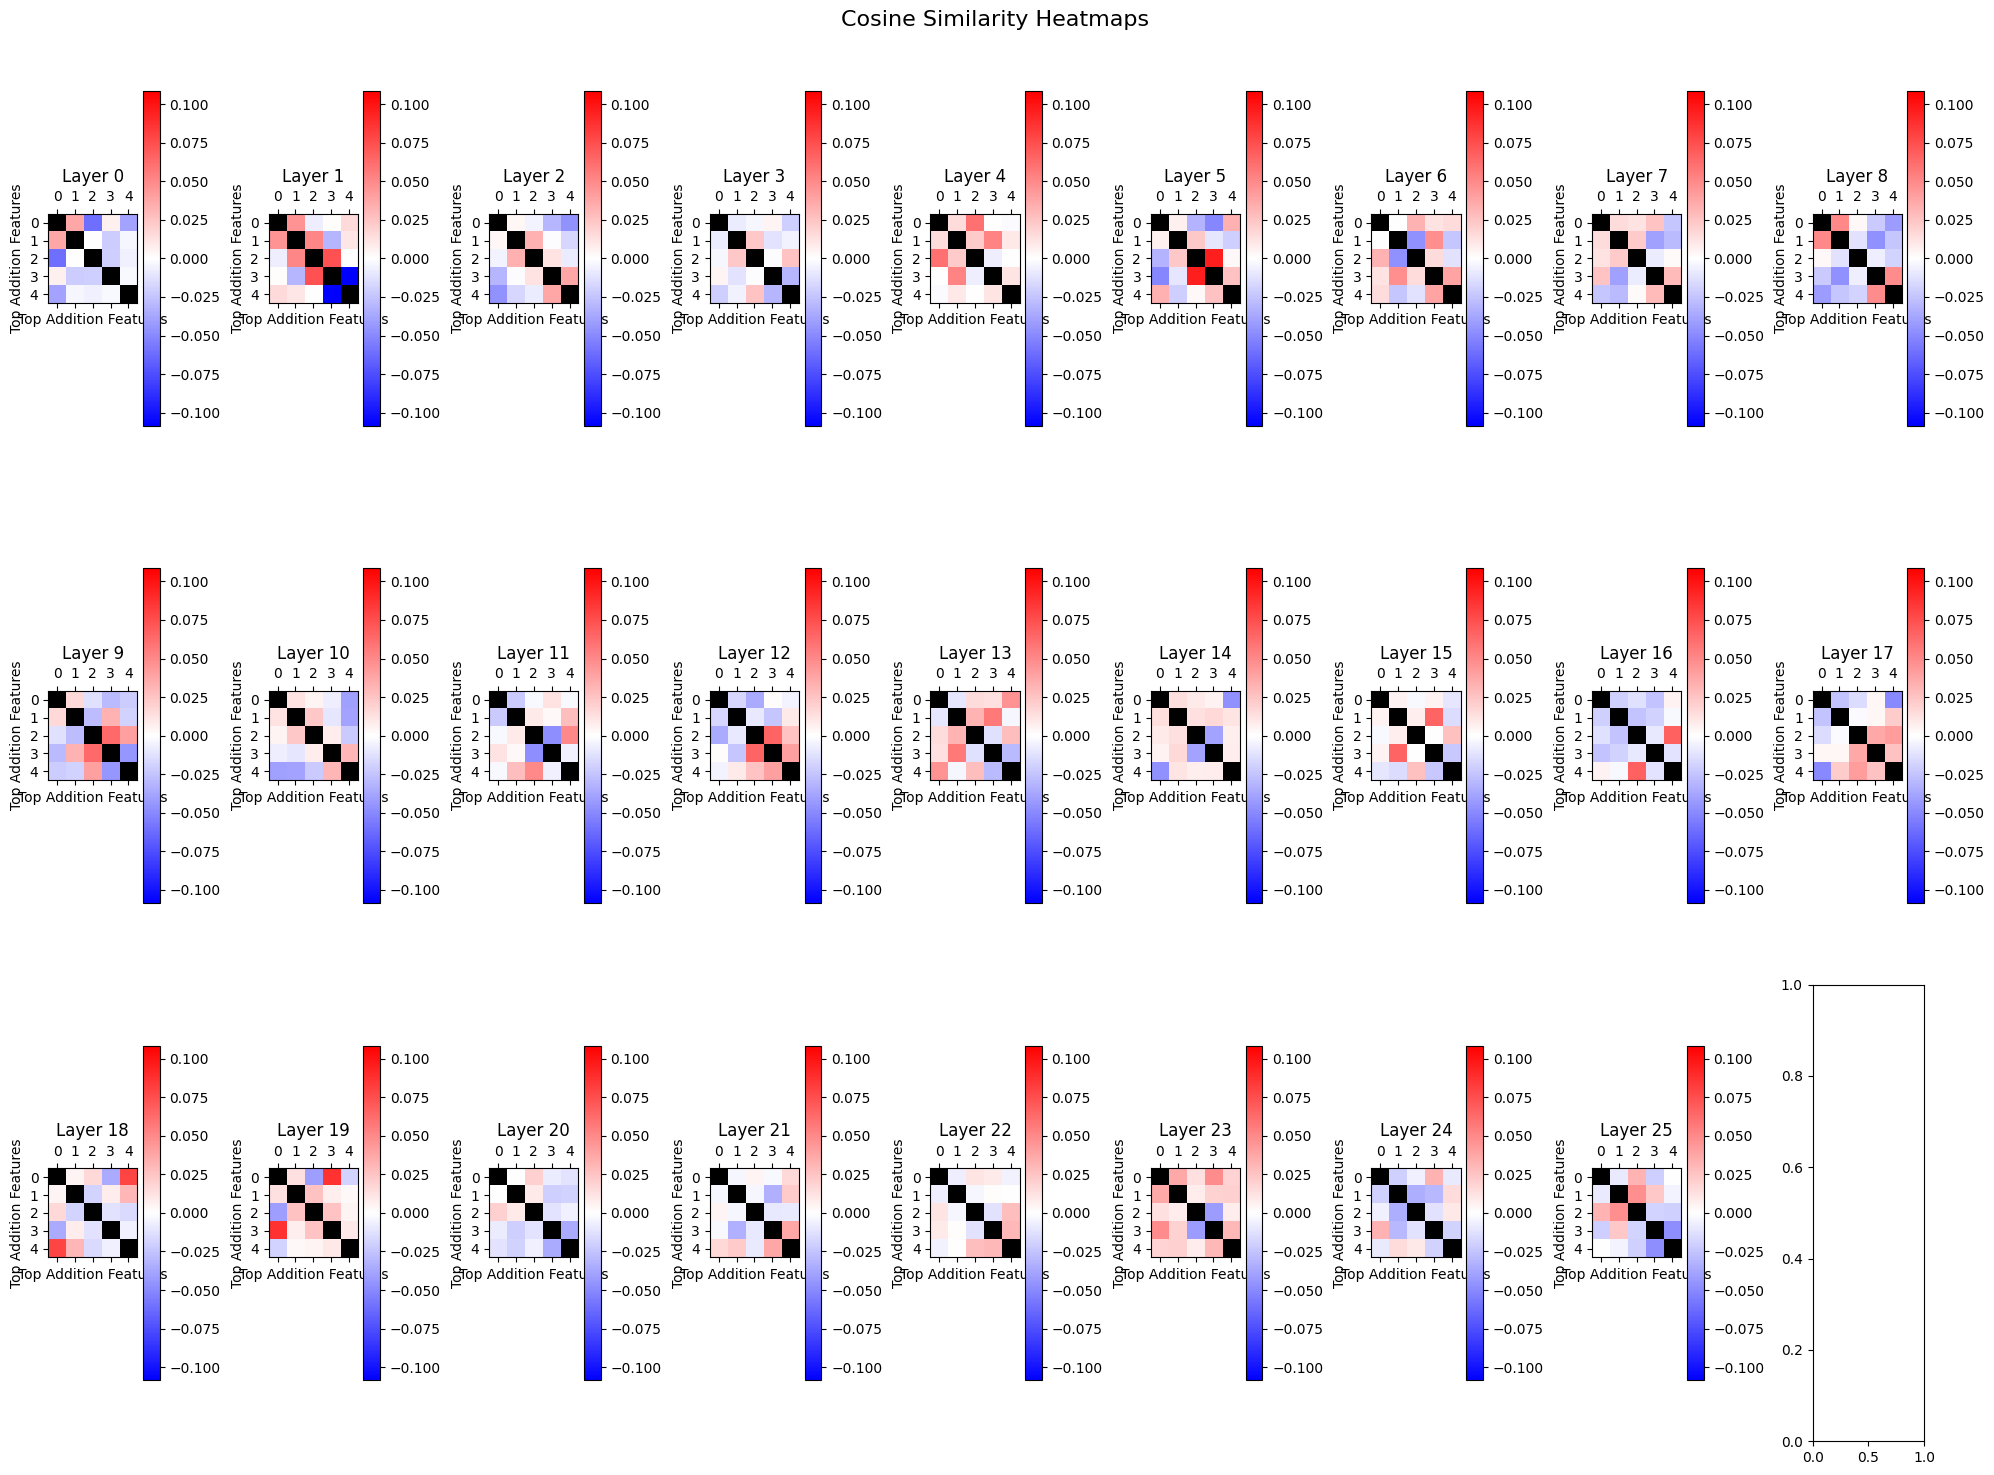

In [21]:
plot_cosine_similarity_heatmaps(add_similarities)

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3400706010.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()


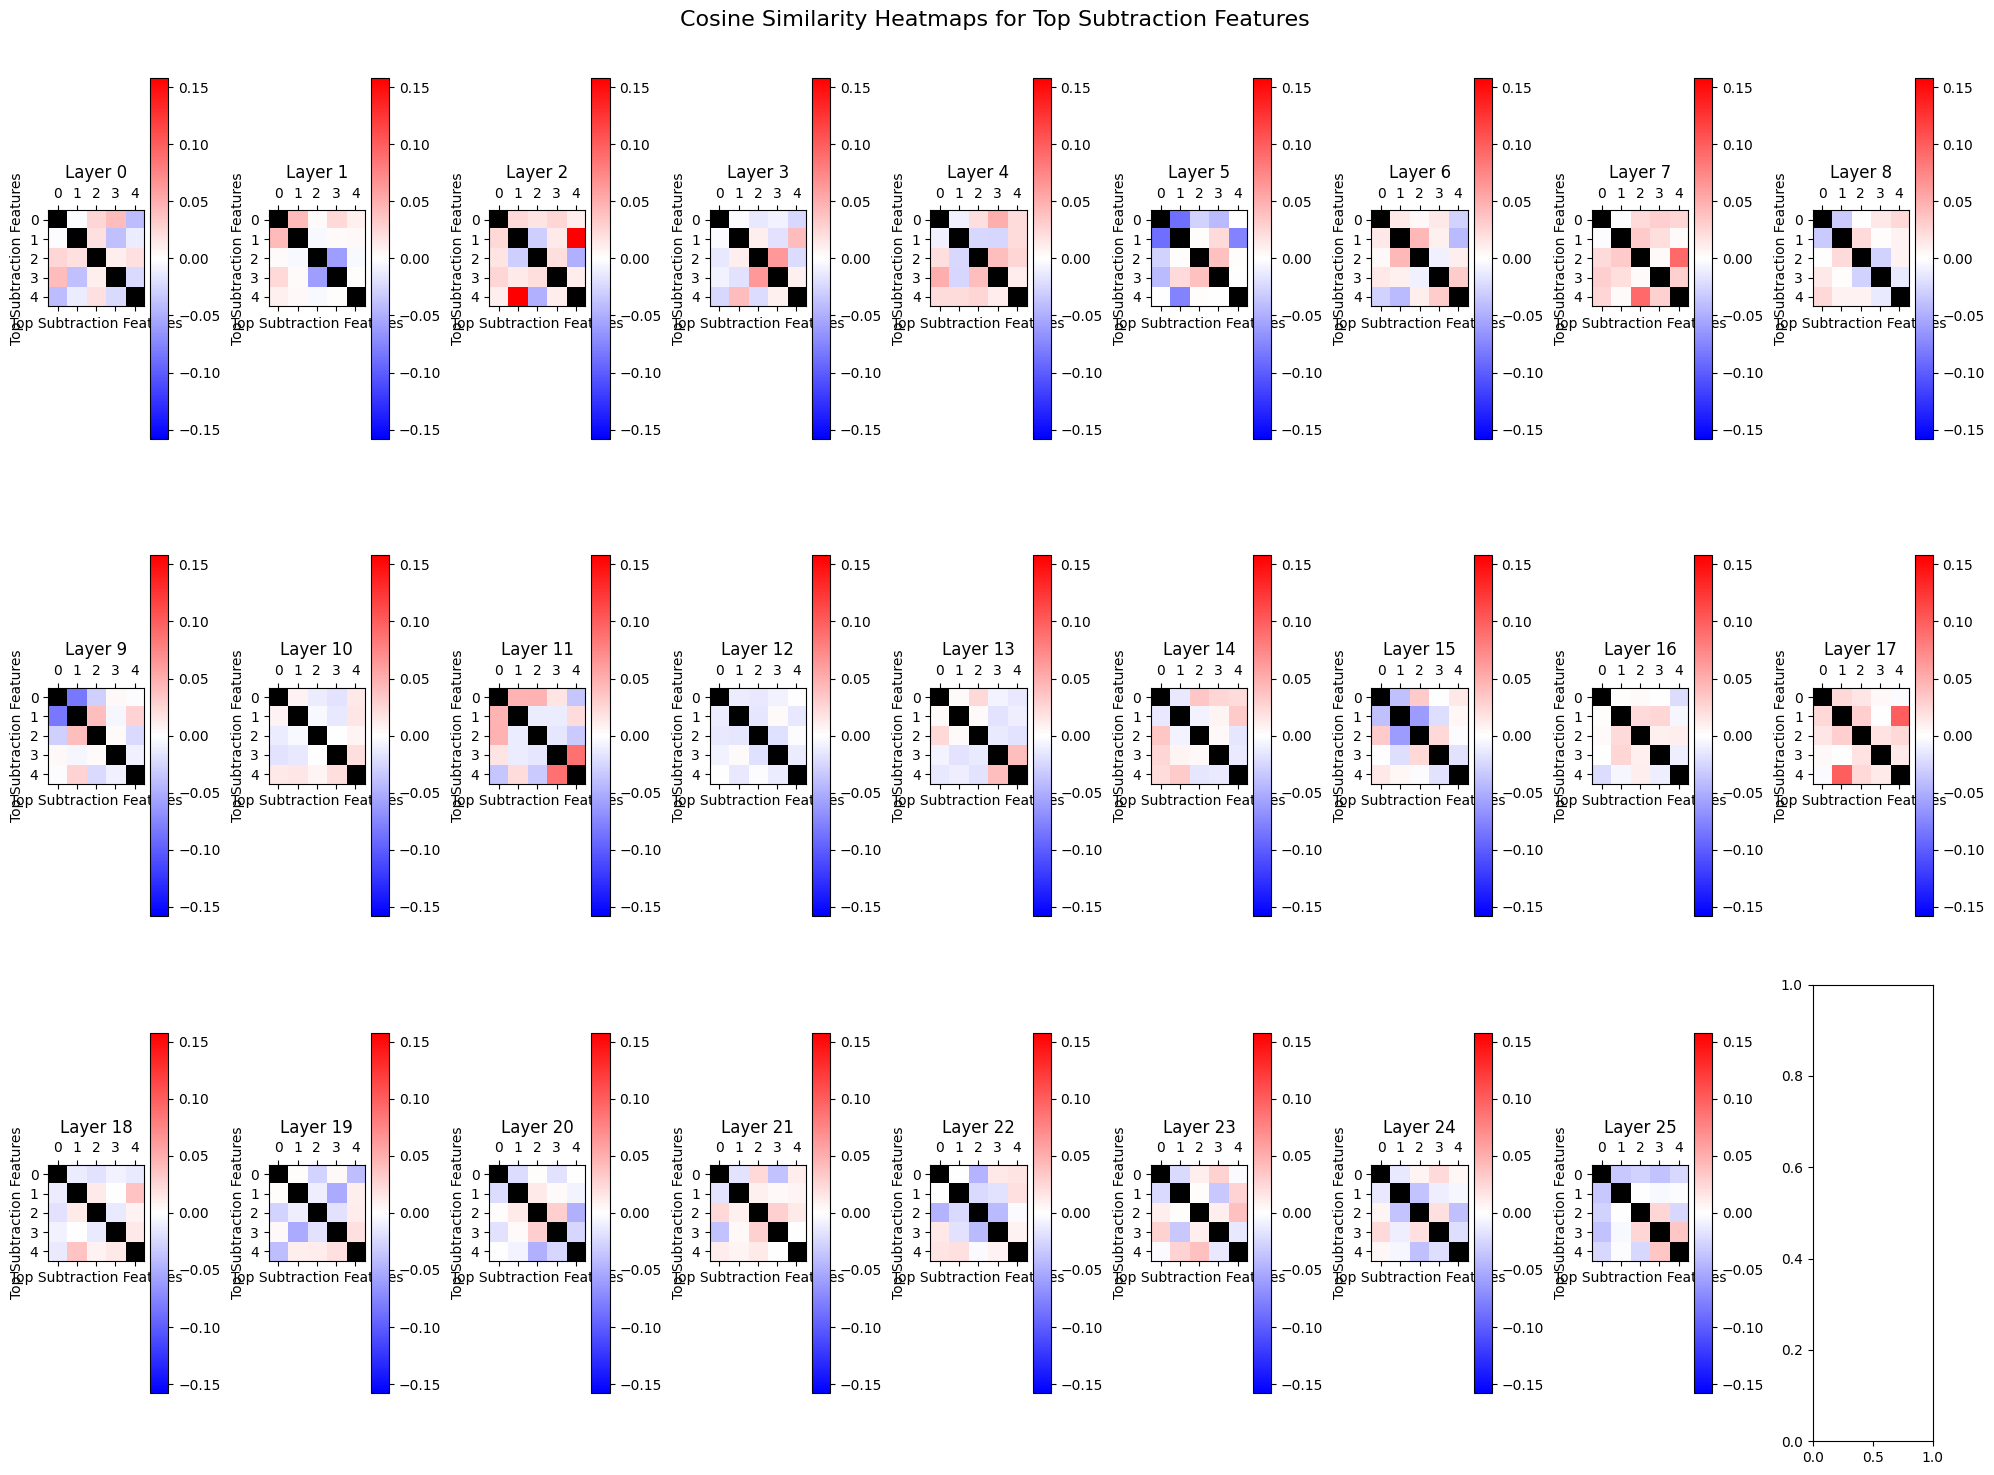

In [22]:
plot_cosine_similarity_heatmaps(sub_similarities, xlabel='Top Subtraction Features', ylabel='Top Subtraction Features', title='Cosine Similarity Heatmaps for Top Subtraction Features')

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3400706010.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()


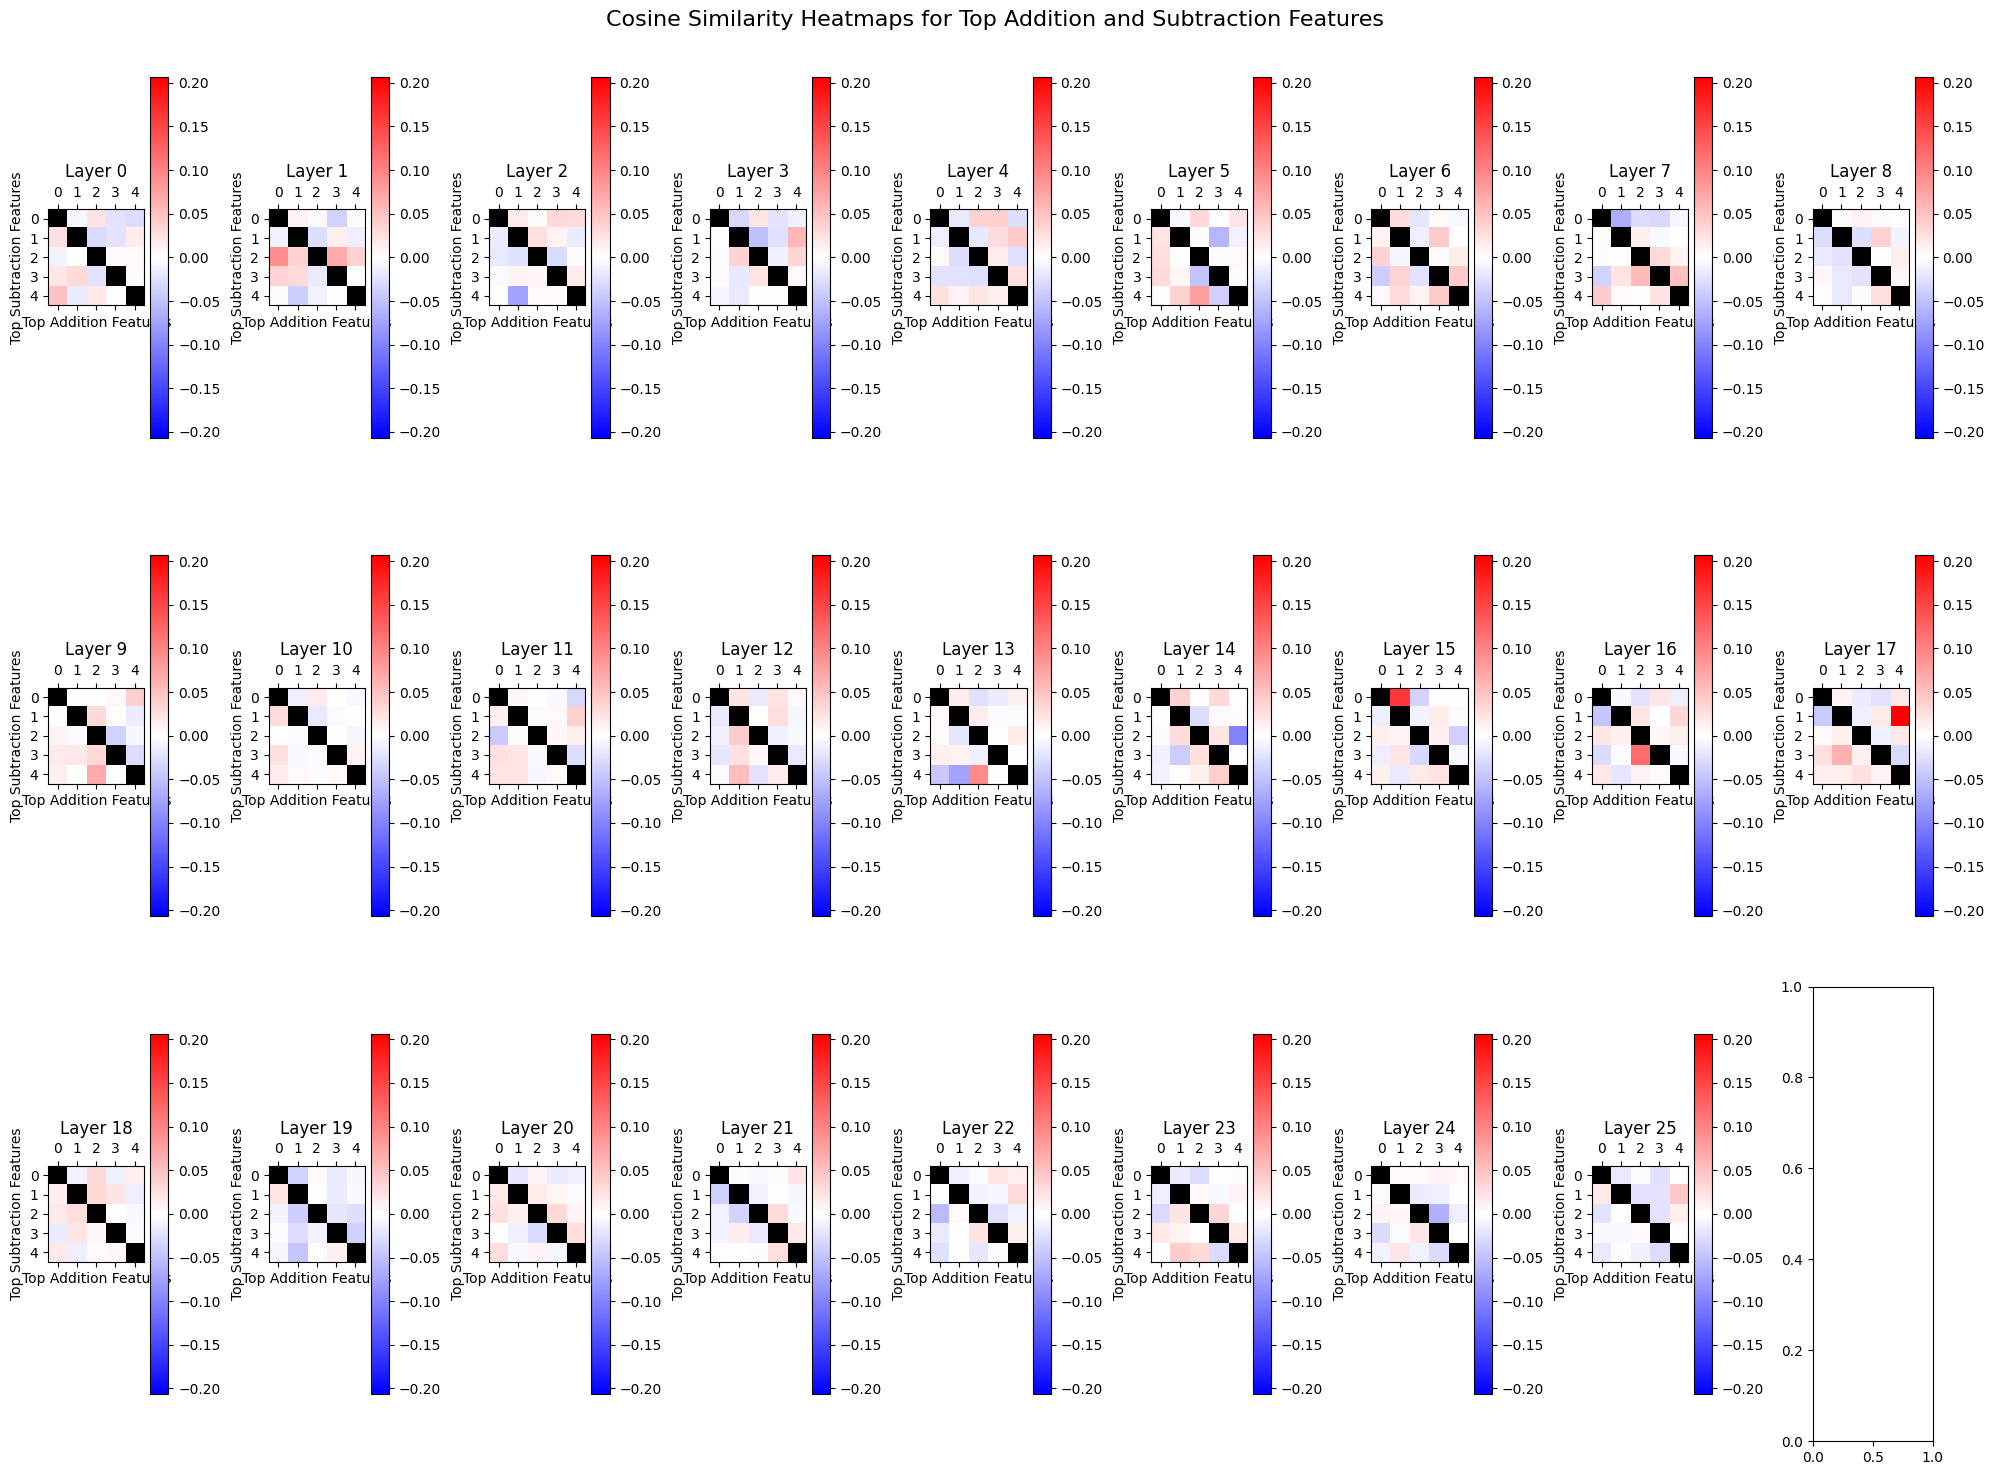

In [23]:
plot_cosine_similarity_heatmaps(add_sub_similarities, xlabel='Top Addition Features', ylabel='Top Subtraction Features', title='Cosine Similarity Heatmaps for Top Addition and Subtraction Features')

In [24]:
# calculate similarity between top features of each layer, and all features of all layers
# return an array of shape 24, 5, 24, 16384, where the first 24 is the layer index of top features, the second 5 is the number of top features, the third 24 is the layer index of all features, and the last 16384 is the feature index
def get_top_features_similarity(top_features_decoders, decoder_vectors):
    num_layers = top_features_decoders.shape[0]
    num_top_features = top_features_decoders.shape[1]
    num_all_features = decoder_vectors.shape[0]
    all_features_dim = decoder_vectors.shape[1]

    similarities = np.zeros((num_layers, num_top_features, num_layers, all_features_dim))

    for layer in range(num_layers):
        for top_idx in range(num_top_features):
            top_vector = top_features_decoders[layer][top_idx]
            for all_layer in range(num_all_features):
                all_vector = decoder_vectors[all_layer]
                sim = np.dot(top_vector, all_vector.T)
                similarities[layer, top_idx, all_layer] = sim

    return similarities
top_features_similarity = get_top_features_similarity(top_features_decoders, decoder_vectors)


In [25]:
top_features_decoders.shape, decoder_vectors.shape, top_features_similarity.shape

((26, 5, 2304), (26, 16384, 2304), (26, 5, 26, 16384))

In [26]:
bottom_features_similarity = get_top_features_similarity(bottom_features_decoders, decoder_vectors)

In [27]:
top_features_similarity.shape

(26, 5, 26, 16384)

In [28]:
# filter the last dimension of top_features_similarity and bottom_features_similarity to get the single feature with the highest similarity
max_similarities_with_top_features = np.max(top_features_similarity, axis=-1)
max_similarities_with_bottom_features = np.max(bottom_features_similarity, axis=-1)

min_similarities_with_top_features = np.min(top_features_similarity, axis=-1)
min_similarities_with_bottom_features = np.min(bottom_features_similarity, axis=-1)

In [29]:
max_similarities_with_top_features.shape

(26, 5, 26)

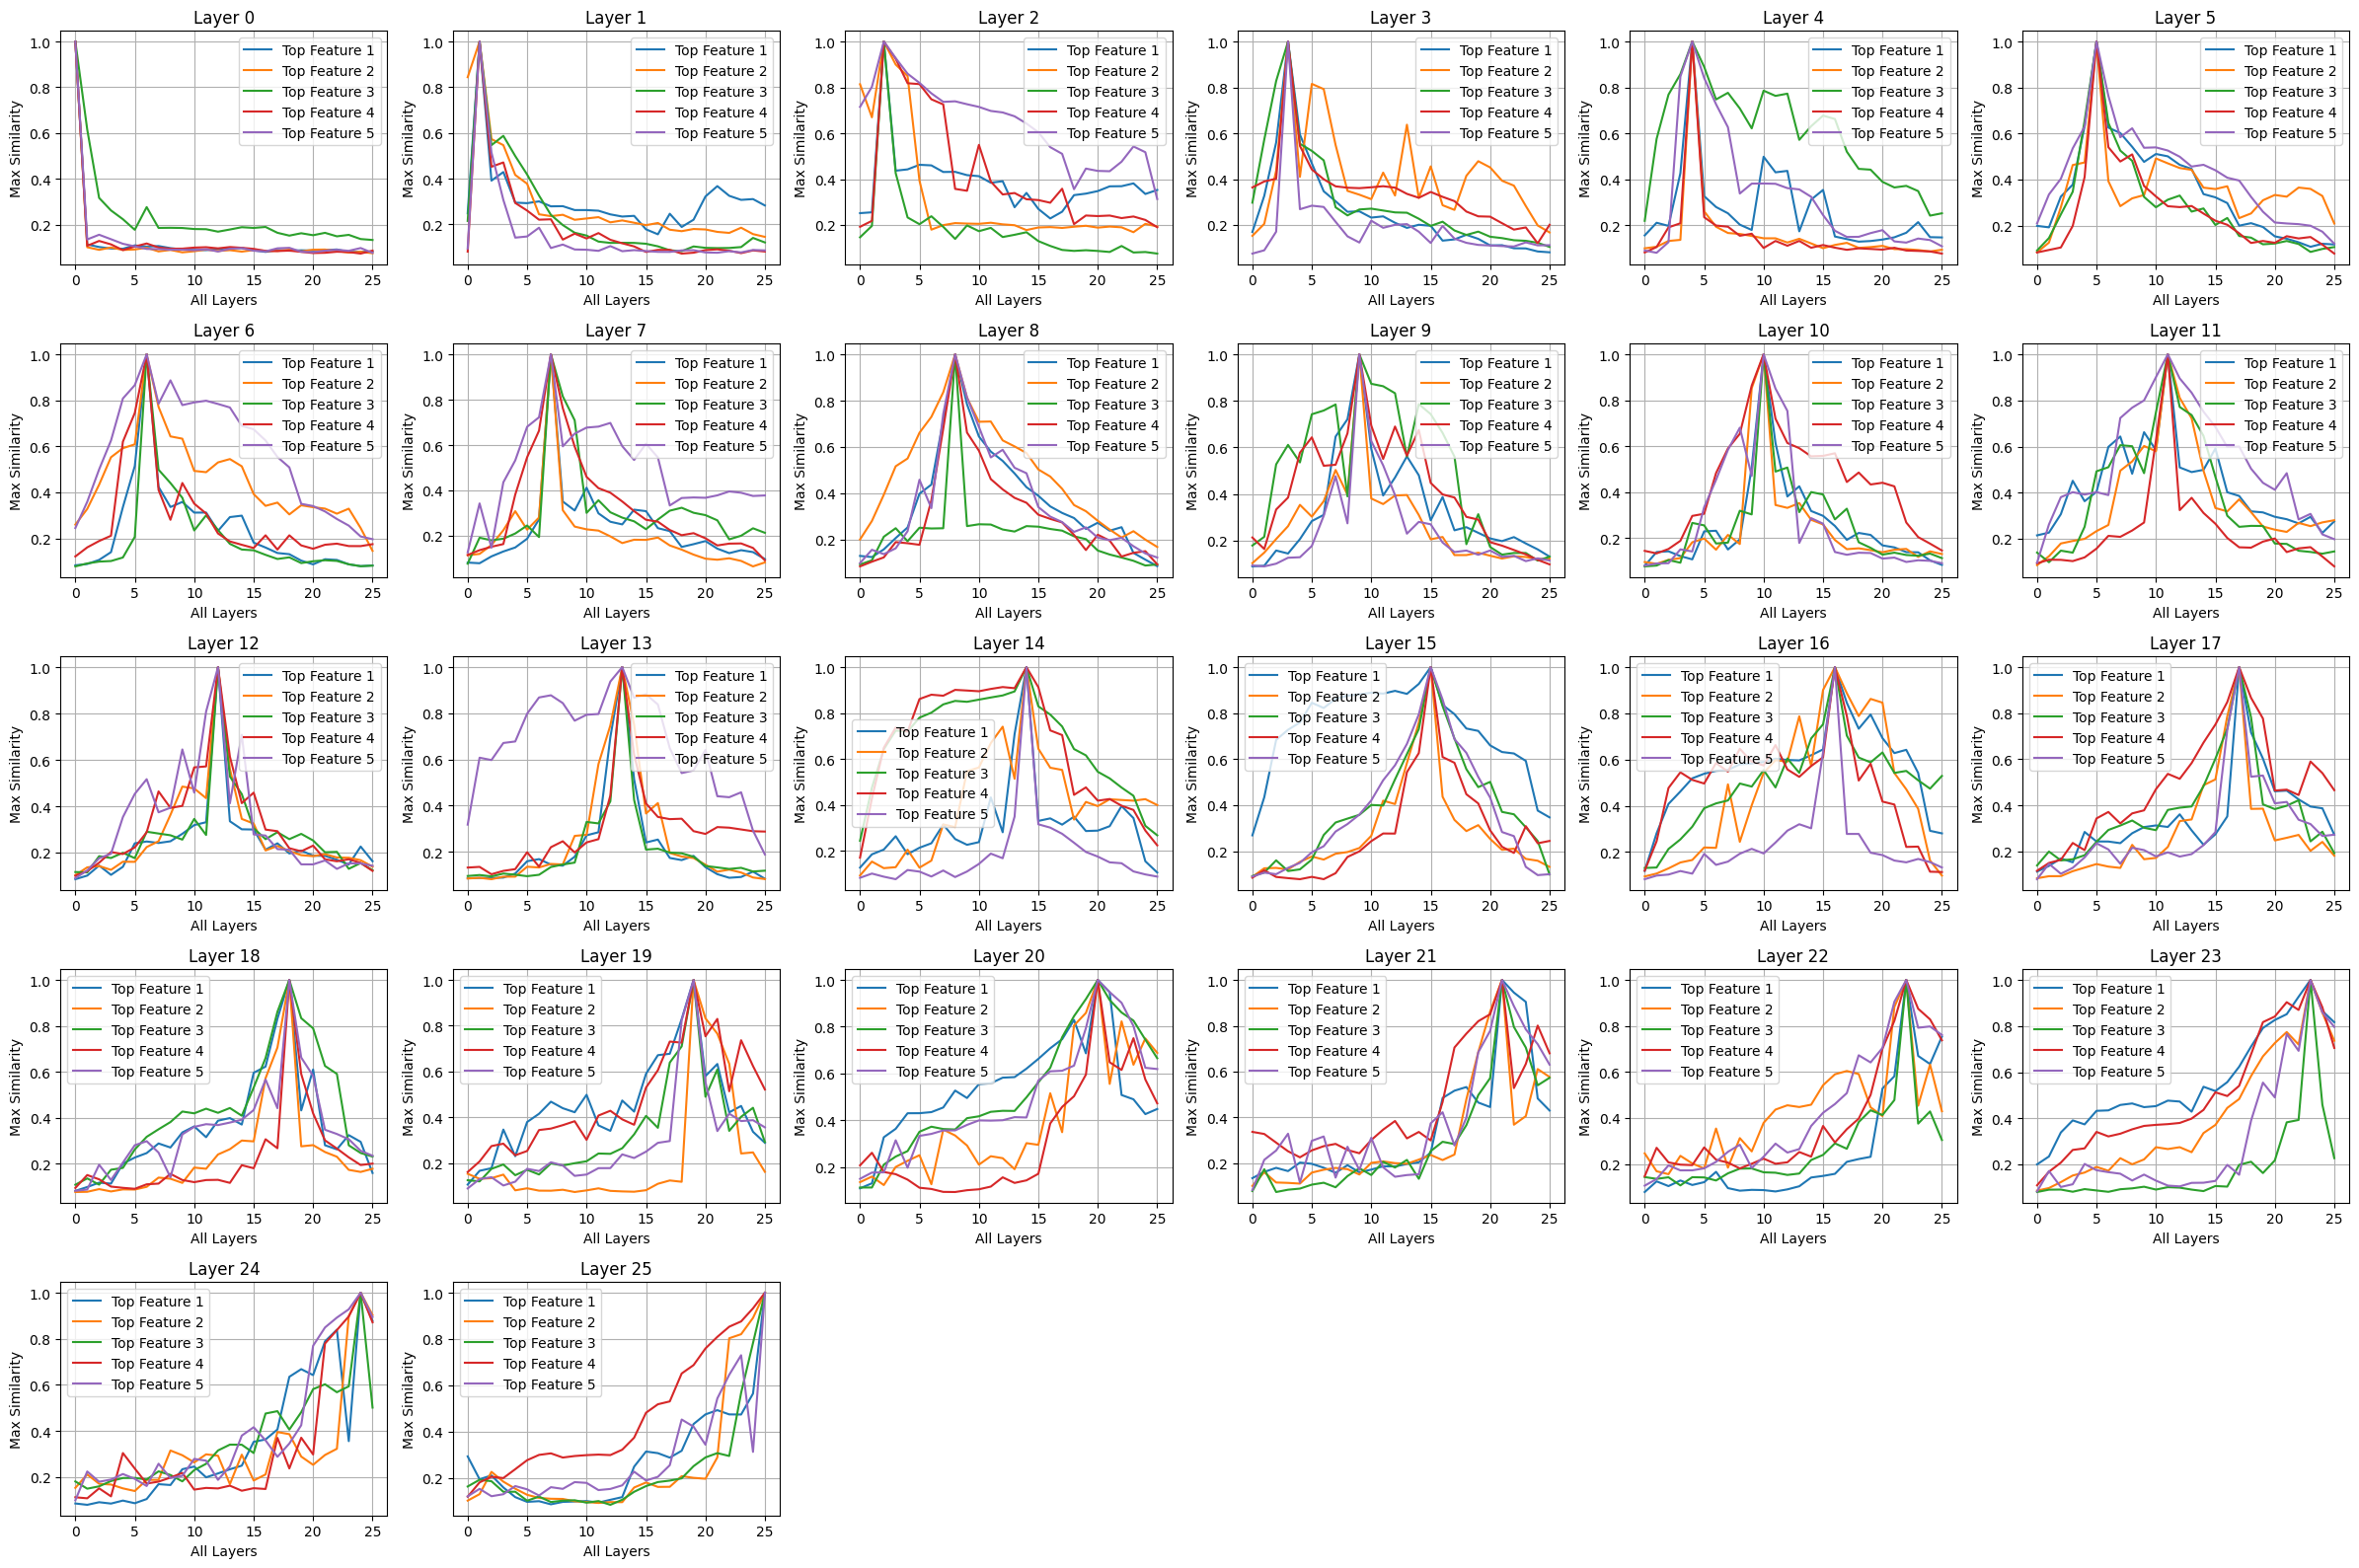

In [30]:
# create 26 subplots, each one is a line plot for a layer, and each one has 5 lines, one for each top feature, showing the max similarity with all features of all layers
def plot_top_features_similarity(max_similarities_with_top_features):
    num_layers = max_similarities_with_top_features.shape[0]
    num_top_features = max_similarities_with_top_features.shape[1]

    plt.figure(figsize=(24, 16))
    for layer in range(num_layers):
        plt.subplot(5, 6, layer + 1)  # 5 rows x 6 columns for 26 layers
        for top_idx in range(num_top_features):
            plt.plot(max_similarities_with_top_features[layer, top_idx], label=f'Top Feature {top_idx + 1}')
        plt.title(f'Layer {layer}')
        plt.xlabel('All Layers')
        plt.ylabel('Max Similarity')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_top_features_similarity(max_similarities_with_top_features)

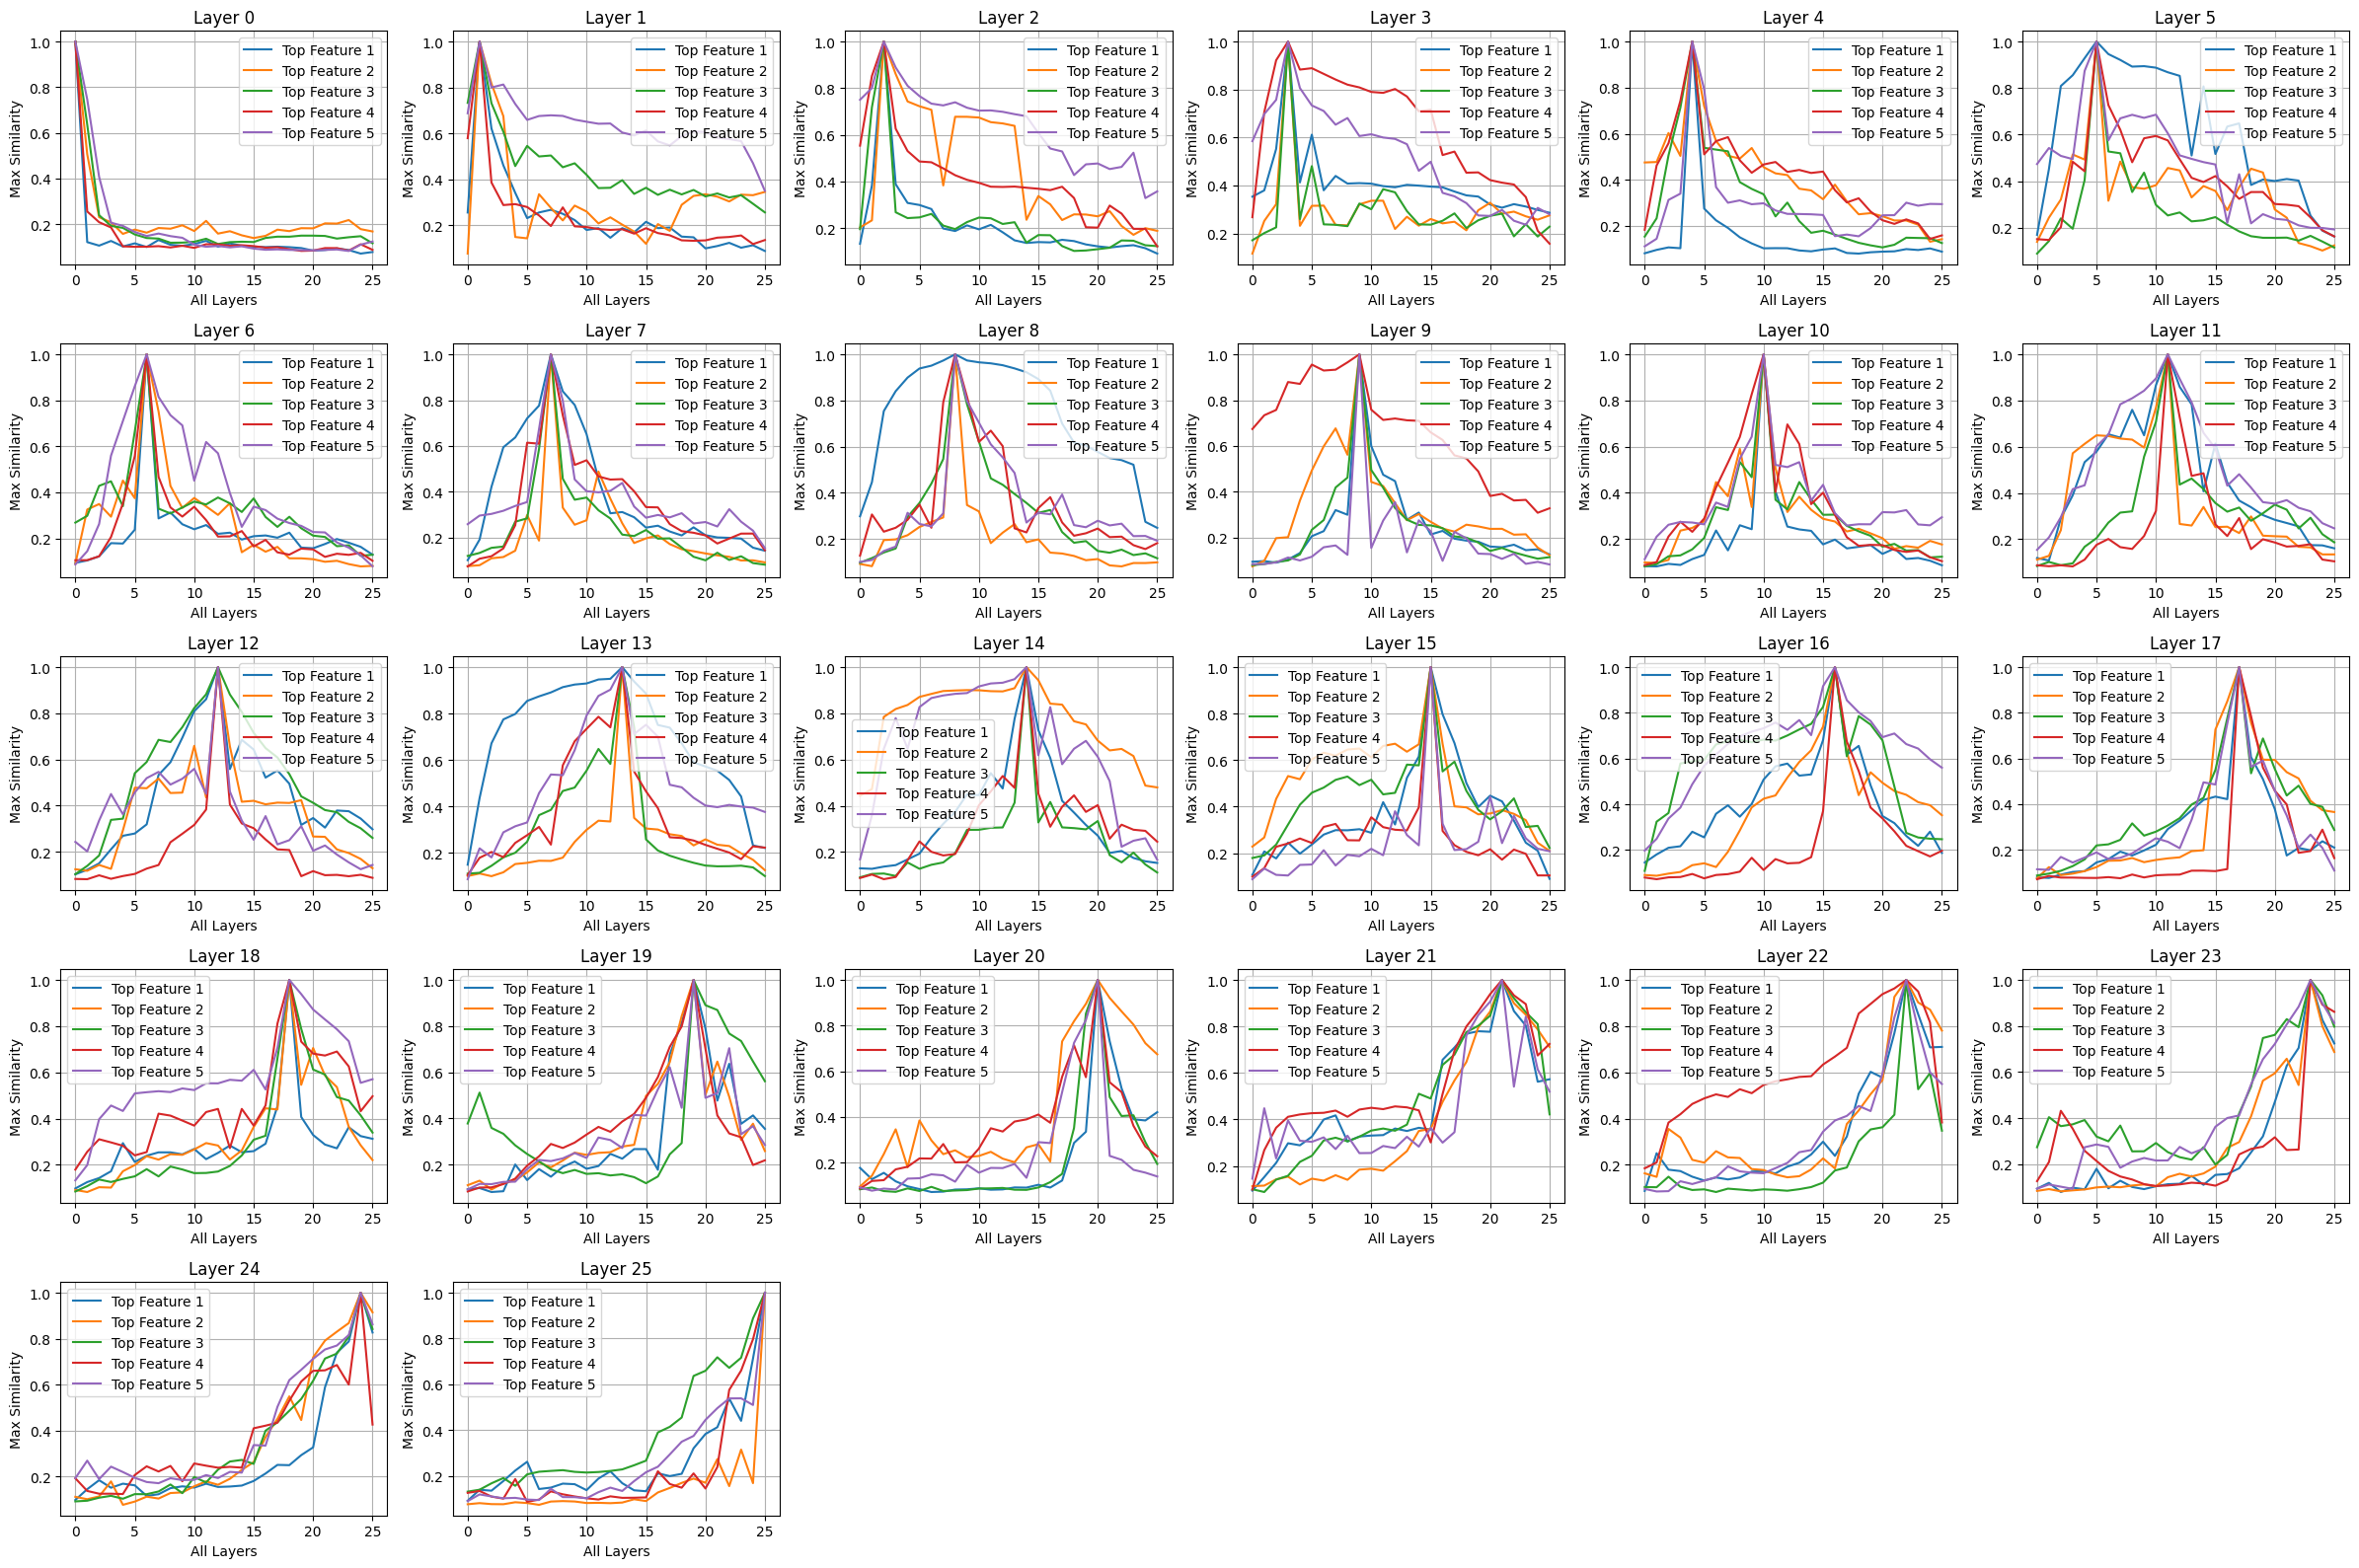

In [31]:
plot_top_features_similarity(max_similarities_with_bottom_features)

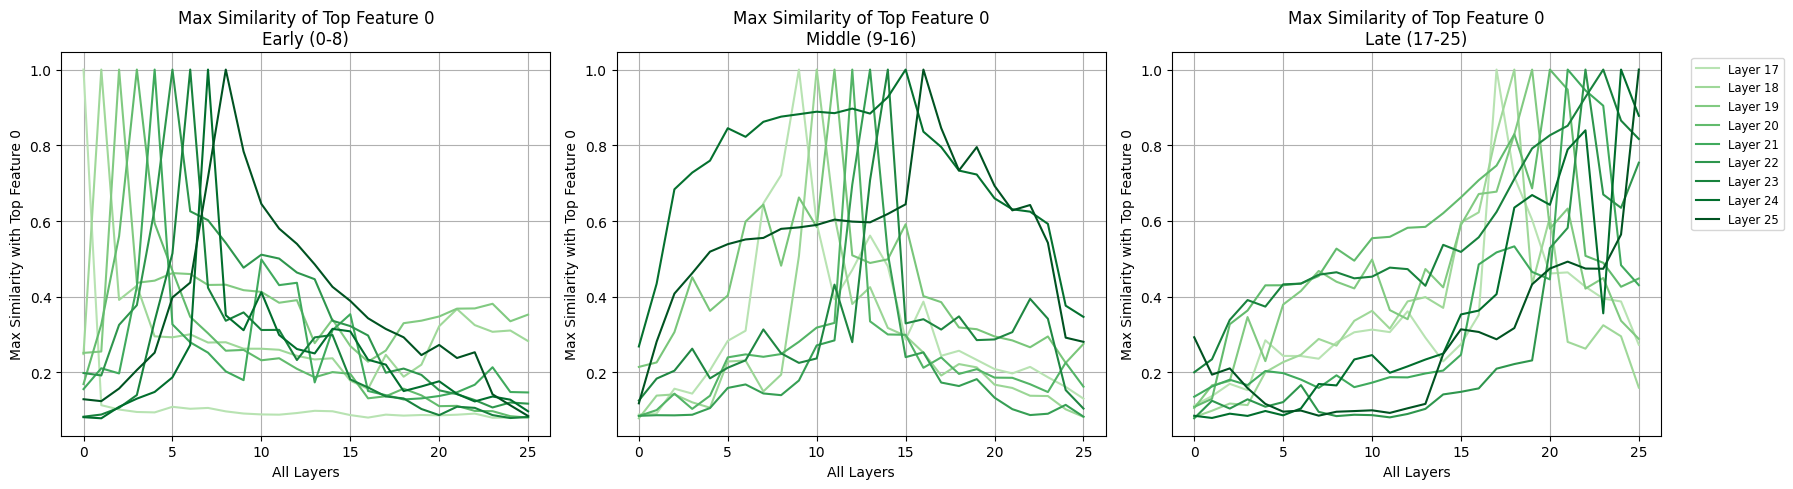

In [32]:
def plot_max_similarity_by_stage(max_similarities, feature_idx=0, color_map=cm.Greens, ylabel=None, title_prefix='Max Similarity of Top Feature', use_ylim= False):
    stages = {
        'Early (0-8)': (0, 9),
        'Middle (9-16)': (9, 17),
        'Late (17-25)': (17, 26)
    }
    plt.figure(figsize=(18, 5))
    for i, (stage, (start, end)) in enumerate(stages.items()):
        plt.subplot(1, 3, i + 1)
        num_layers = end - start
        colors = color_map(np.linspace(0.3, 0.95, num_layers))
        for j, layer in enumerate(range(start, end)):
            plt.plot(
                max_similarities[layer, feature_idx],
                label=f'Layer {layer}',
                color=colors[j]
            )
        plt.xlabel('All Layers')
        plt.ylabel(ylabel or f'Max Similarity (Feature {feature_idx})')
        plt.title(f'{title_prefix} {feature_idx}\n{stage}')
        plt.grid(True)
        if i == 2:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    if use_ylim:
        plt.ylim(0, 0.2)
    plt.tight_layout()
    plt.show()
plot_max_similarity_by_stage(max_similarities_with_top_features, feature_idx=0, color_map=cm.Greens, ylabel='Max Similarity with Top Feature 0', title_prefix='Max Similarity of Top Feature')

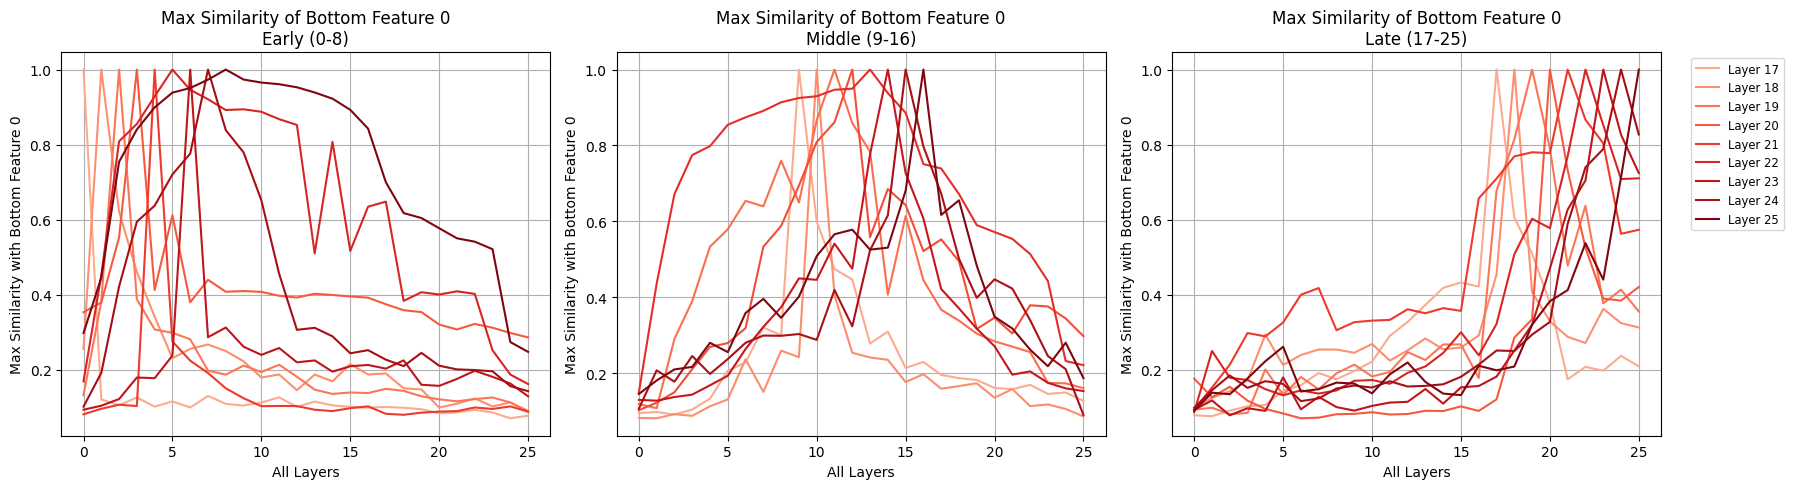

In [33]:
plot_max_similarity_by_stage(max_similarities_with_bottom_features, feature_idx=0, color_map=cm.Reds, ylabel='Max Similarity with Bottom Feature 0', title_prefix='Max Similarity of Bottom Feature')

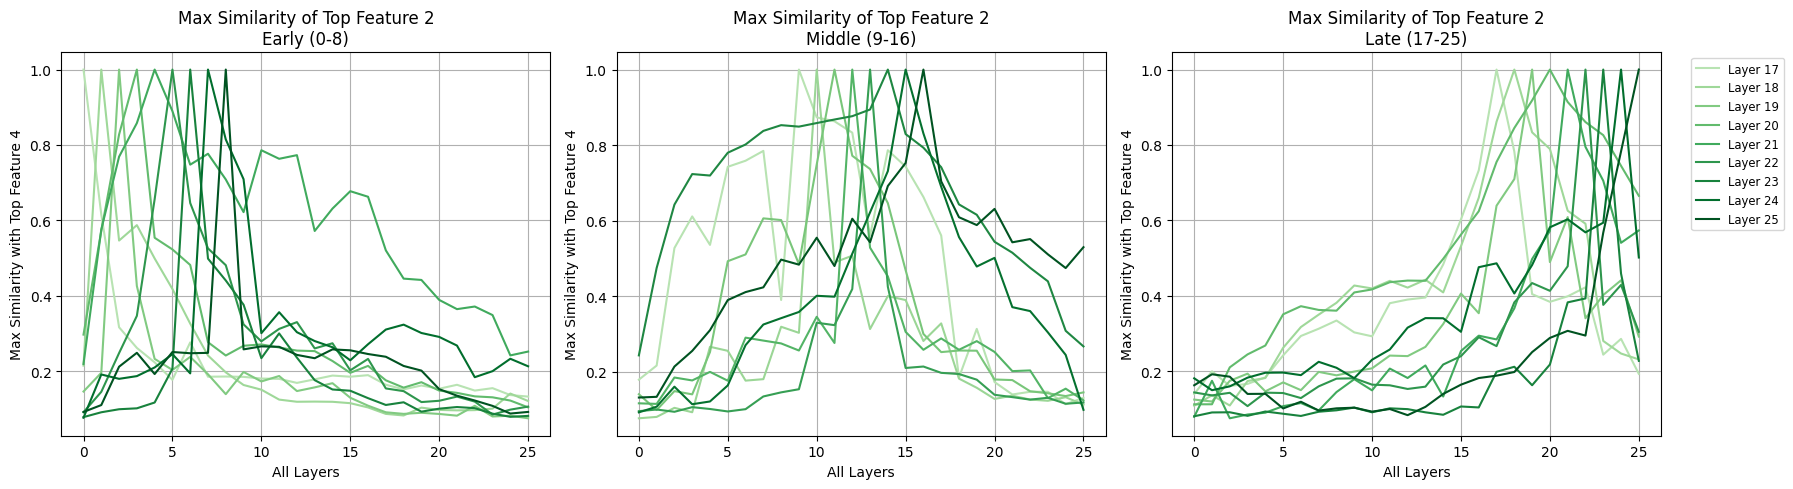

In [34]:
plot_max_similarity_by_stage(max_similarities_with_top_features, feature_idx=2, color_map=cm.Greens, ylabel='Max Similarity with Top Feature 4', title_prefix='Max Similarity of Top Feature')

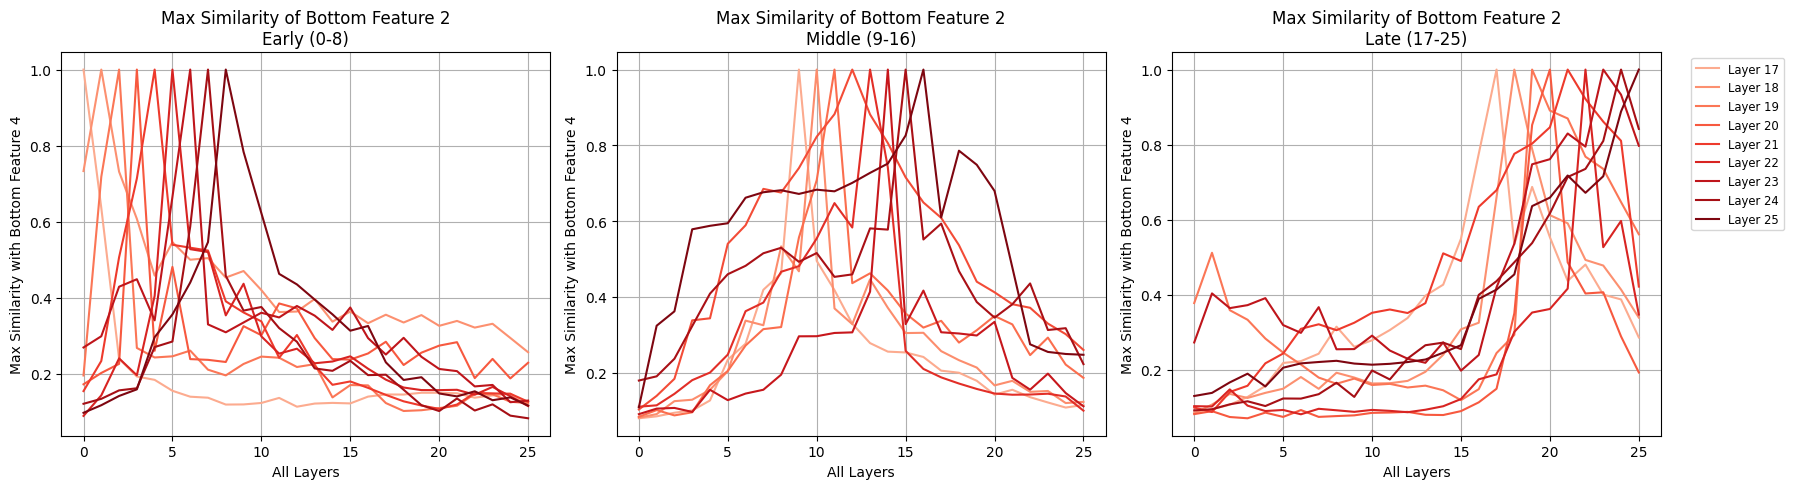

In [35]:
plot_max_similarity_by_stage(max_similarities_with_bottom_features, feature_idx=2, color_map=cm.Reds, ylabel='Max Similarity with Bottom Feature 4', title_prefix='Max Similarity of Bottom Feature')

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3231950223.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()


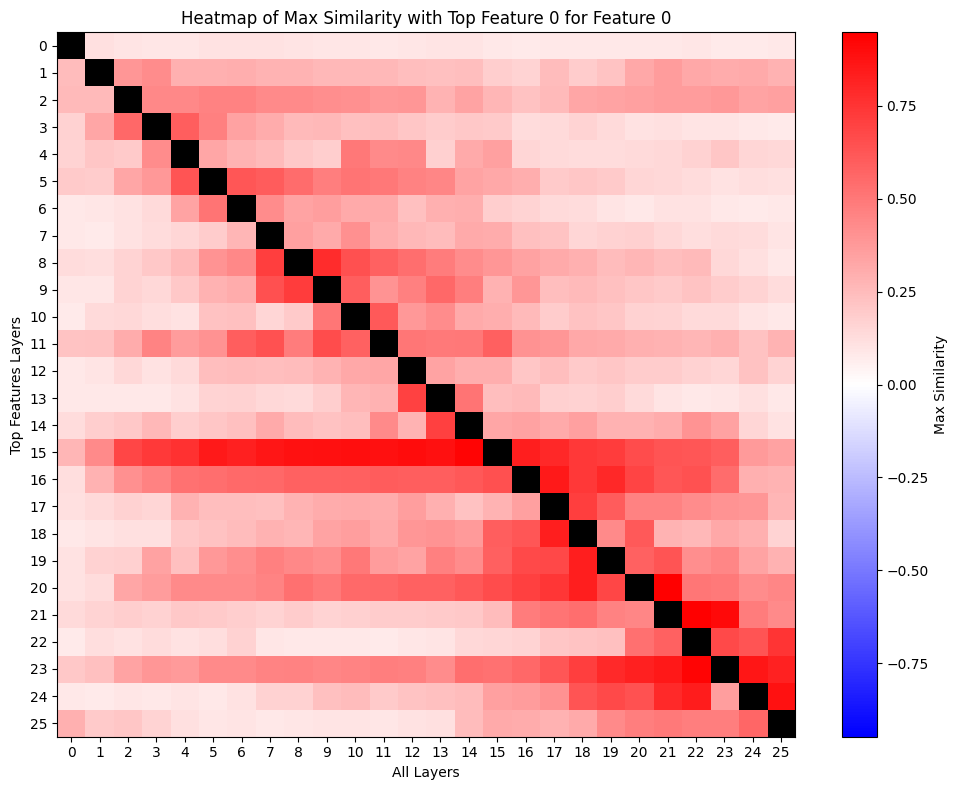

In [36]:
def plot_heatmap_max_similarity(max_similarities, feature_idx=0, title='Heatmap of Max Similarity'):
    data = max_similarities[:, feature_idx, :]
    # Set diagonal to nan for black color
    data = data.copy()
    np.fill_diagonal(data, np.nan)
    # Get non-diagonal values for color range
    mask = ~np.eye(data.shape[0], dtype=bool)
    non_diag_vals = data[mask]
    vabs = max(abs(np.nanmin(non_diag_vals)), abs(np.nanmax(non_diag_vals)))
    vmin, vmax = -vabs, vabs

    cmap = plt.cm.get_cmap('bwr').copy()
    cmap.set_bad(color='black')

    plt.figure(figsize=(10, 8))
    im = plt.imshow(data, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(im, label='Max Similarity')
    plt.title(f'{title} for Feature {feature_idx}')
    plt.xlabel('All Layers')
    plt.ylabel('Top Features Layers')
    plt.xticks(ticks=np.arange(data.shape[1]), labels=np.arange(data.shape[1]))
    plt.yticks(ticks=np.arange(data.shape[0]), labels=np.arange(data.shape[0]))
    plt.tight_layout()
    plt.show()
plot_heatmap_max_similarity(max_similarities_with_top_features, feature_idx=0, title='Heatmap of Max Similarity with Top Feature 0')

In [37]:
max_similarities_with_top_features.shape

(26, 5, 26)

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3231950223.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()


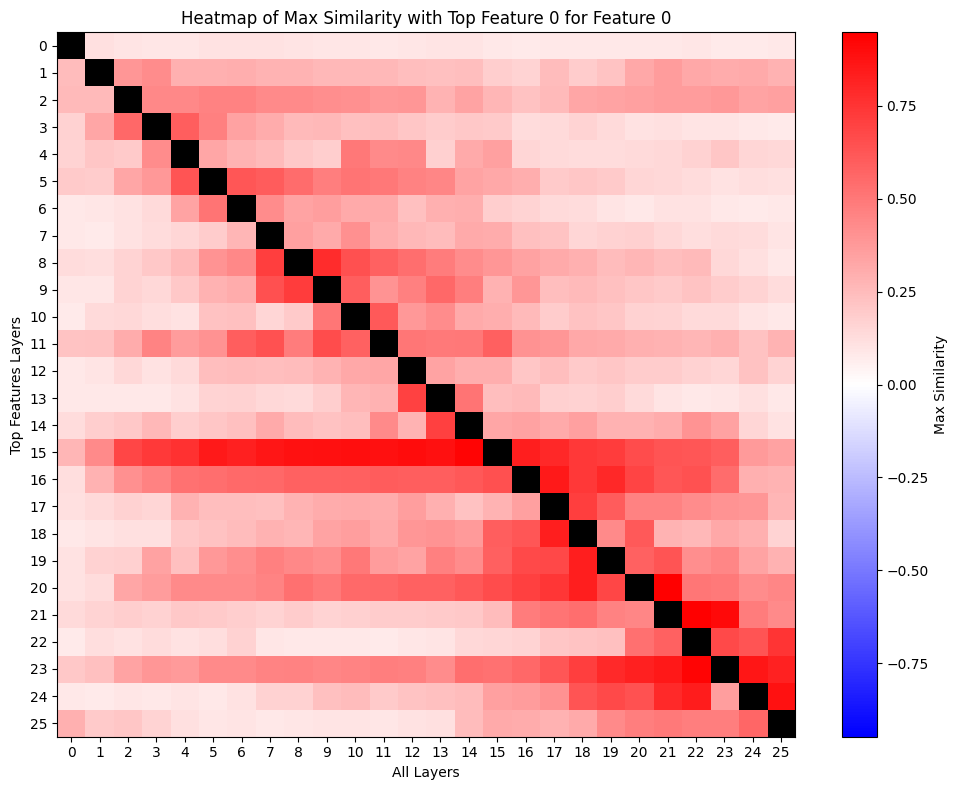

In [38]:
plot_heatmap_max_similarity(max_similarities_with_top_features, feature_idx=0, title='Heatmap of Max Similarity with Top Feature 0')

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3231950223.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()


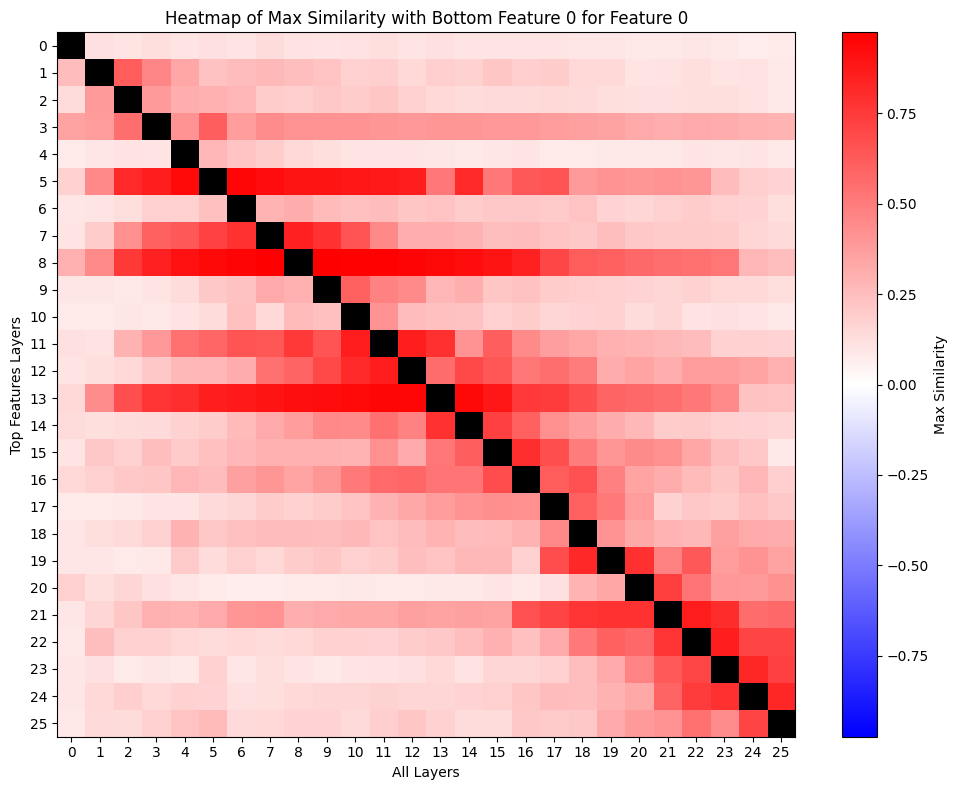

In [39]:
plot_heatmap_max_similarity(max_similarities_with_bottom_features, feature_idx=0, title='Heatmap of Max Similarity with Bottom Feature 0')

In [40]:
max_similarities_with_bottom_features.shape

(26, 5, 26)

In [ ]:
assert 0

# create plots that show similarities between addition anchors across layers. 
and similarly for subtraction, and then between addition and subtraction

forward hooks in pytorch: i HAVE A Few resources open regarding this (monosemanticity blog, and some pytorch stuff). we discussed the idea before, of removing a feature's representation after decoding it, in activation space, from the LLMs activation.
remember the plots about features ablated vs performance. 

Shape of similarities: (26, 5, 26, 5)


C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3983518517.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()


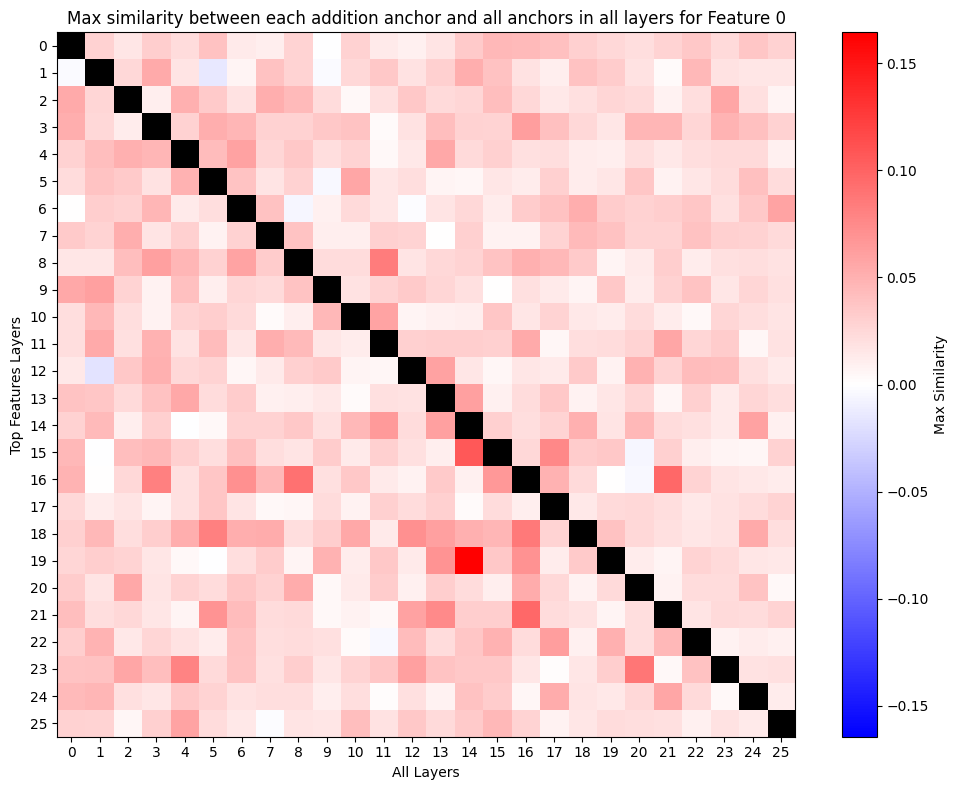

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3983518517.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()


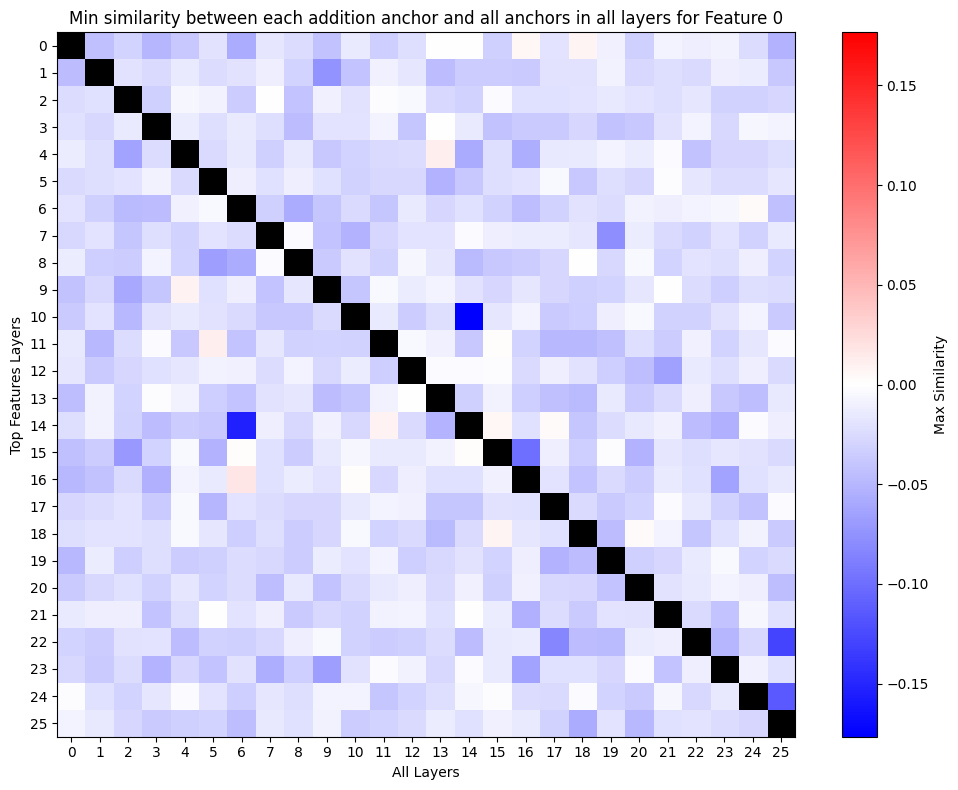

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3983518517.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()


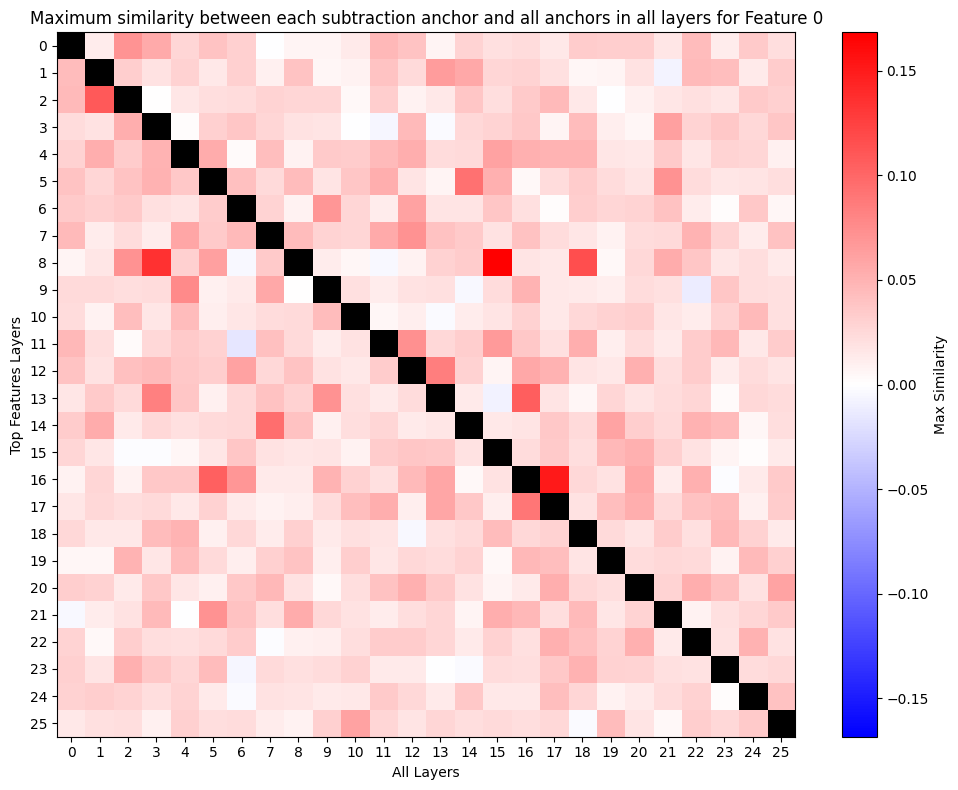

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3983518517.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()


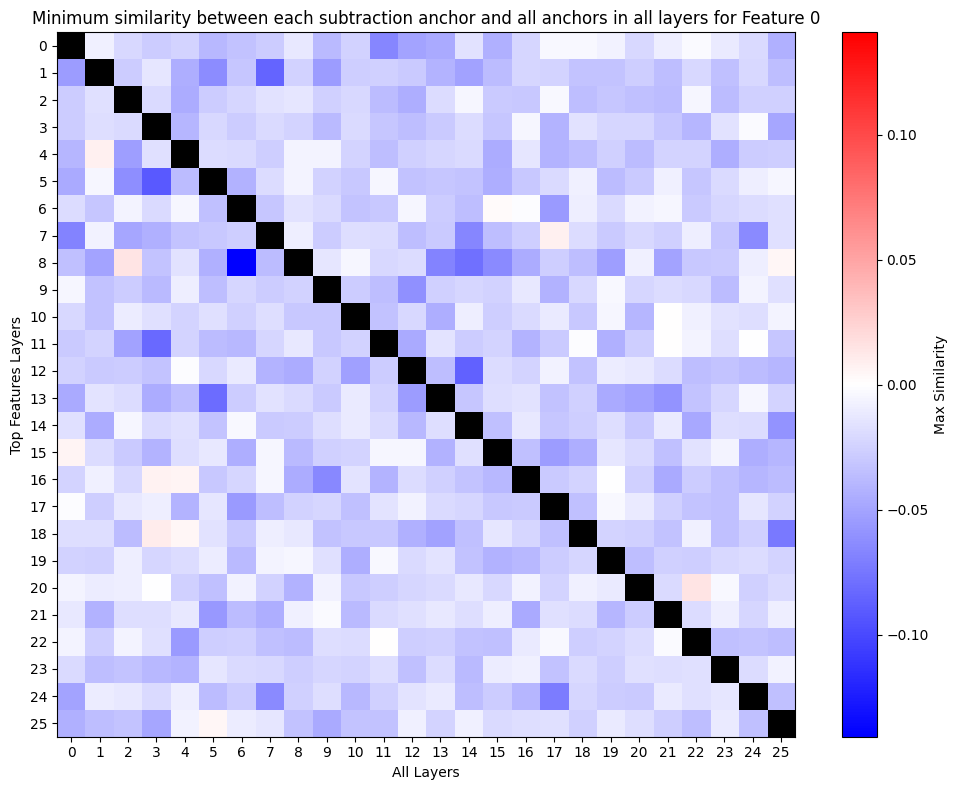

In [41]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_layer_to_layer_cosine_similarity_vectorized(top_features_decoders):
    """
    Vectorized version for better performance.
    
    Args:
        top_features_decoders: numpy array of shape (24, 5, 2304)
    
    Returns:
        similarities: numpy array of shape (24, 5, 24, 5)
    """
    num_layers, num_features, vector_dim = top_features_decoders.shape
    
    # Reshape to (24*5, 2304) for efficient computation
    all_vectors = top_features_decoders.reshape(-1, vector_dim)
    
    # Calculate cosine similarity for all pairs at once
    all_similarities = cosine_similarity(all_vectors)  # shape: (120, 120)
    
    # Reshape back to (24, 5, 24, 5)
    similarities = all_similarities.reshape(num_layers, num_features, num_layers, num_features)
    
    return similarities


addition_similarities = calculate_layer_to_layer_cosine_similarity_vectorized(top_features_decoders)
subtraction_similarities = calculate_layer_to_layer_cosine_similarity_vectorized(bottom_features_decoders)


max_anchor_similarities = np.max(addition_similarities, axis=-1)  # shape: (24, 5, 24)
min_anchor_similarities = np.min(addition_similarities, axis=-1)  # shape: (24, 5, 24)

max_subtraction_anchor_similarities = np.max(subtraction_similarities, axis=-1)  # shape: (24, 5, 24)
min_subtraction_anchor_similarities = np.min(subtraction_similarities, axis=-1)  # shape: (24, 5, 24)


print("Shape of similarities:", addition_similarities.shape)


def plot_heatmap_max_similarity(max_similarities, feature_idx=0, title='Heatmap of Max Similarity'):
    data = max_similarities[:, feature_idx, :]
    # Set diagonal to nan for black color
    data = data.copy()
    np.fill_diagonal(data, np.nan)
    # Get non-diagonal values for color range
    mask = ~np.eye(data.shape[0], dtype=bool)
    non_diag_vals = data[mask]
    vabs = max(abs(np.nanmin(non_diag_vals)), abs(np.nanmax(non_diag_vals)))
    vmin, vmax = -vabs, vabs

    cmap = plt.cm.get_cmap('bwr').copy()
    cmap.set_bad(color='black')

    plt.figure(figsize=(10, 8))
    im = plt.imshow(data, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(im, label='Max Similarity')
    plt.title(f'{title} for Feature {feature_idx}')
    plt.xlabel('All Layers')
    plt.ylabel('Top Features Layers')
    plt.xticks(ticks=np.arange(data.shape[1]), labels=np.arange(data.shape[1]))
    plt.yticks(ticks=np.arange(data.shape[0]), labels=np.arange(data.shape[0]))
    plt.tight_layout()
    plt.show()


plot_heatmap_max_similarity(max_anchor_similarities, feature_idx=0, title='Max similarity between each addition anchor and all anchors in all layers')
plot_heatmap_max_similarity(min_anchor_similarities, feature_idx=0, title='Min similarity between each addition anchor and all anchors in all layers')

plot_heatmap_max_similarity(max_subtraction_anchor_similarities, feature_idx=0, title='Maximum similarity between each subtraction anchor and all anchors in all layers')
plot_heatmap_max_similarity(min_subtraction_anchor_similarities, feature_idx=0, title='Minimum similarity between each subtraction anchor and all anchors in all layers')

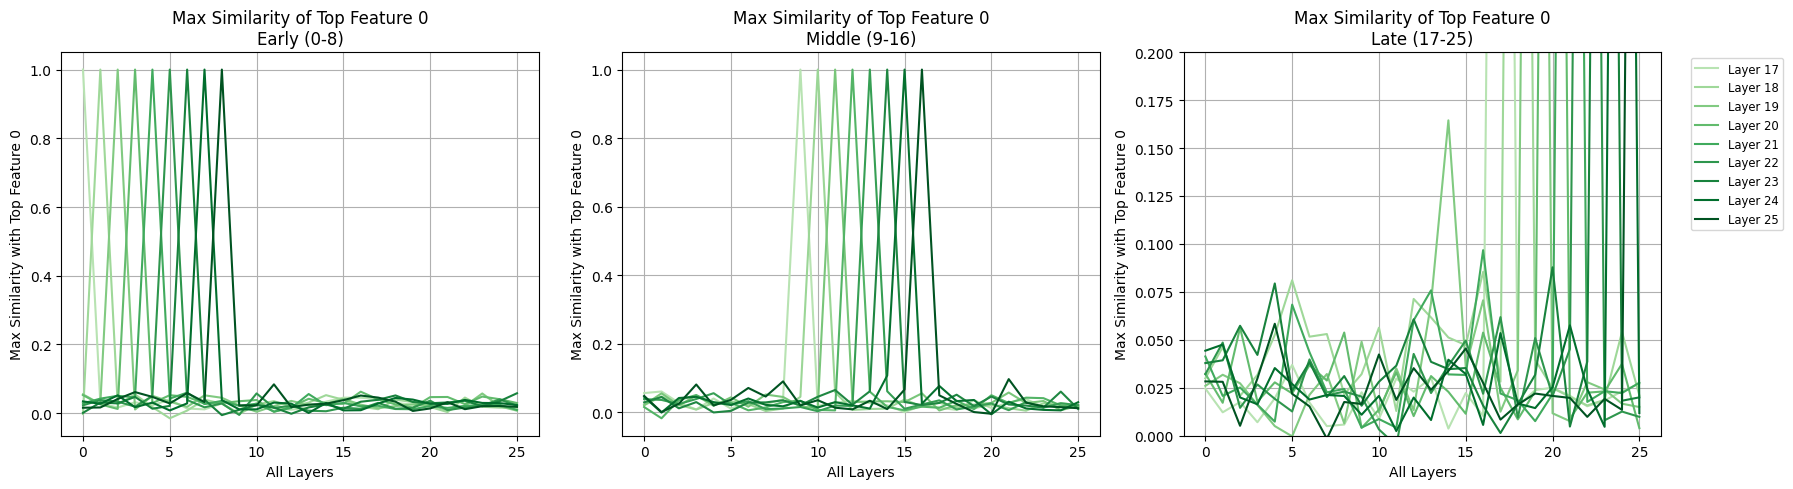

In [42]:
plot_max_similarity_by_stage(max_anchor_similarities, feature_idx=0, color_map=cm.Greens, ylabel='Max Similarity with Top Feature 0', title_prefix='Max Similarity of Top Feature', use_ylim=True)

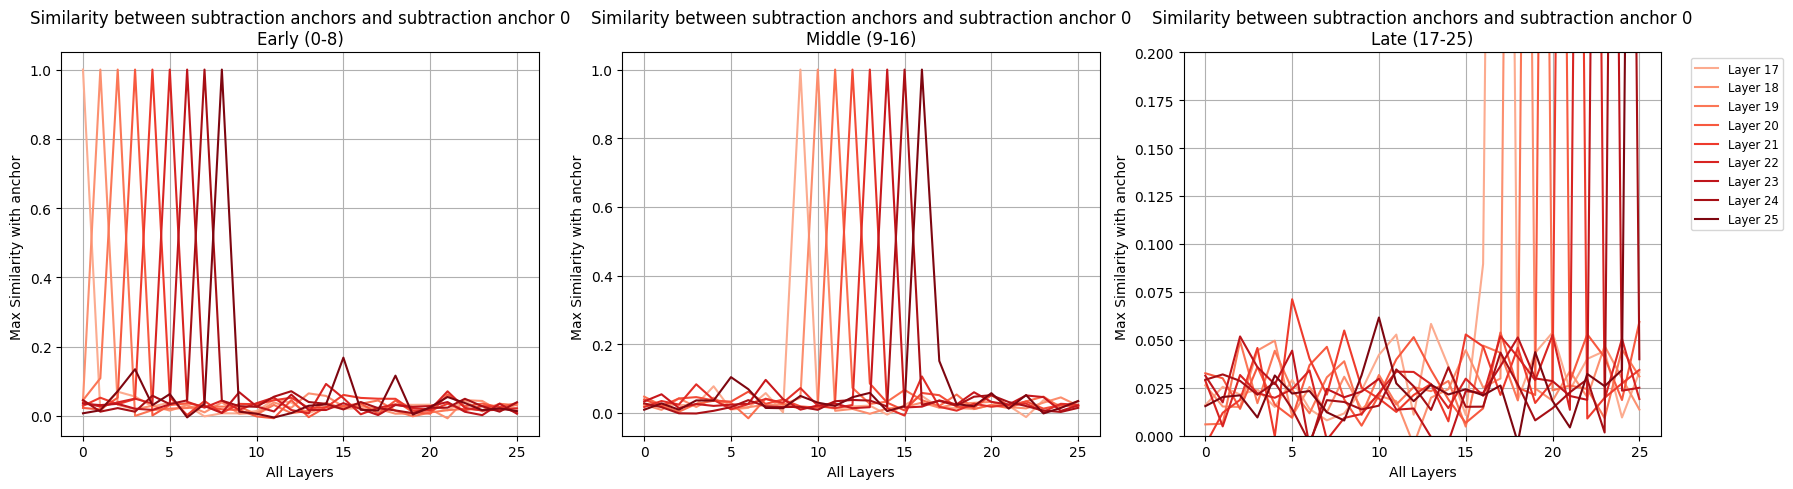

In [43]:
plot_max_similarity_by_stage(max_subtraction_anchor_similarities, feature_idx=0, color_map=cm.Reds, ylabel='Max Similarity with anchor ', title_prefix='Similarity between subtraction anchors and subtraction anchor', use_ylim=True)

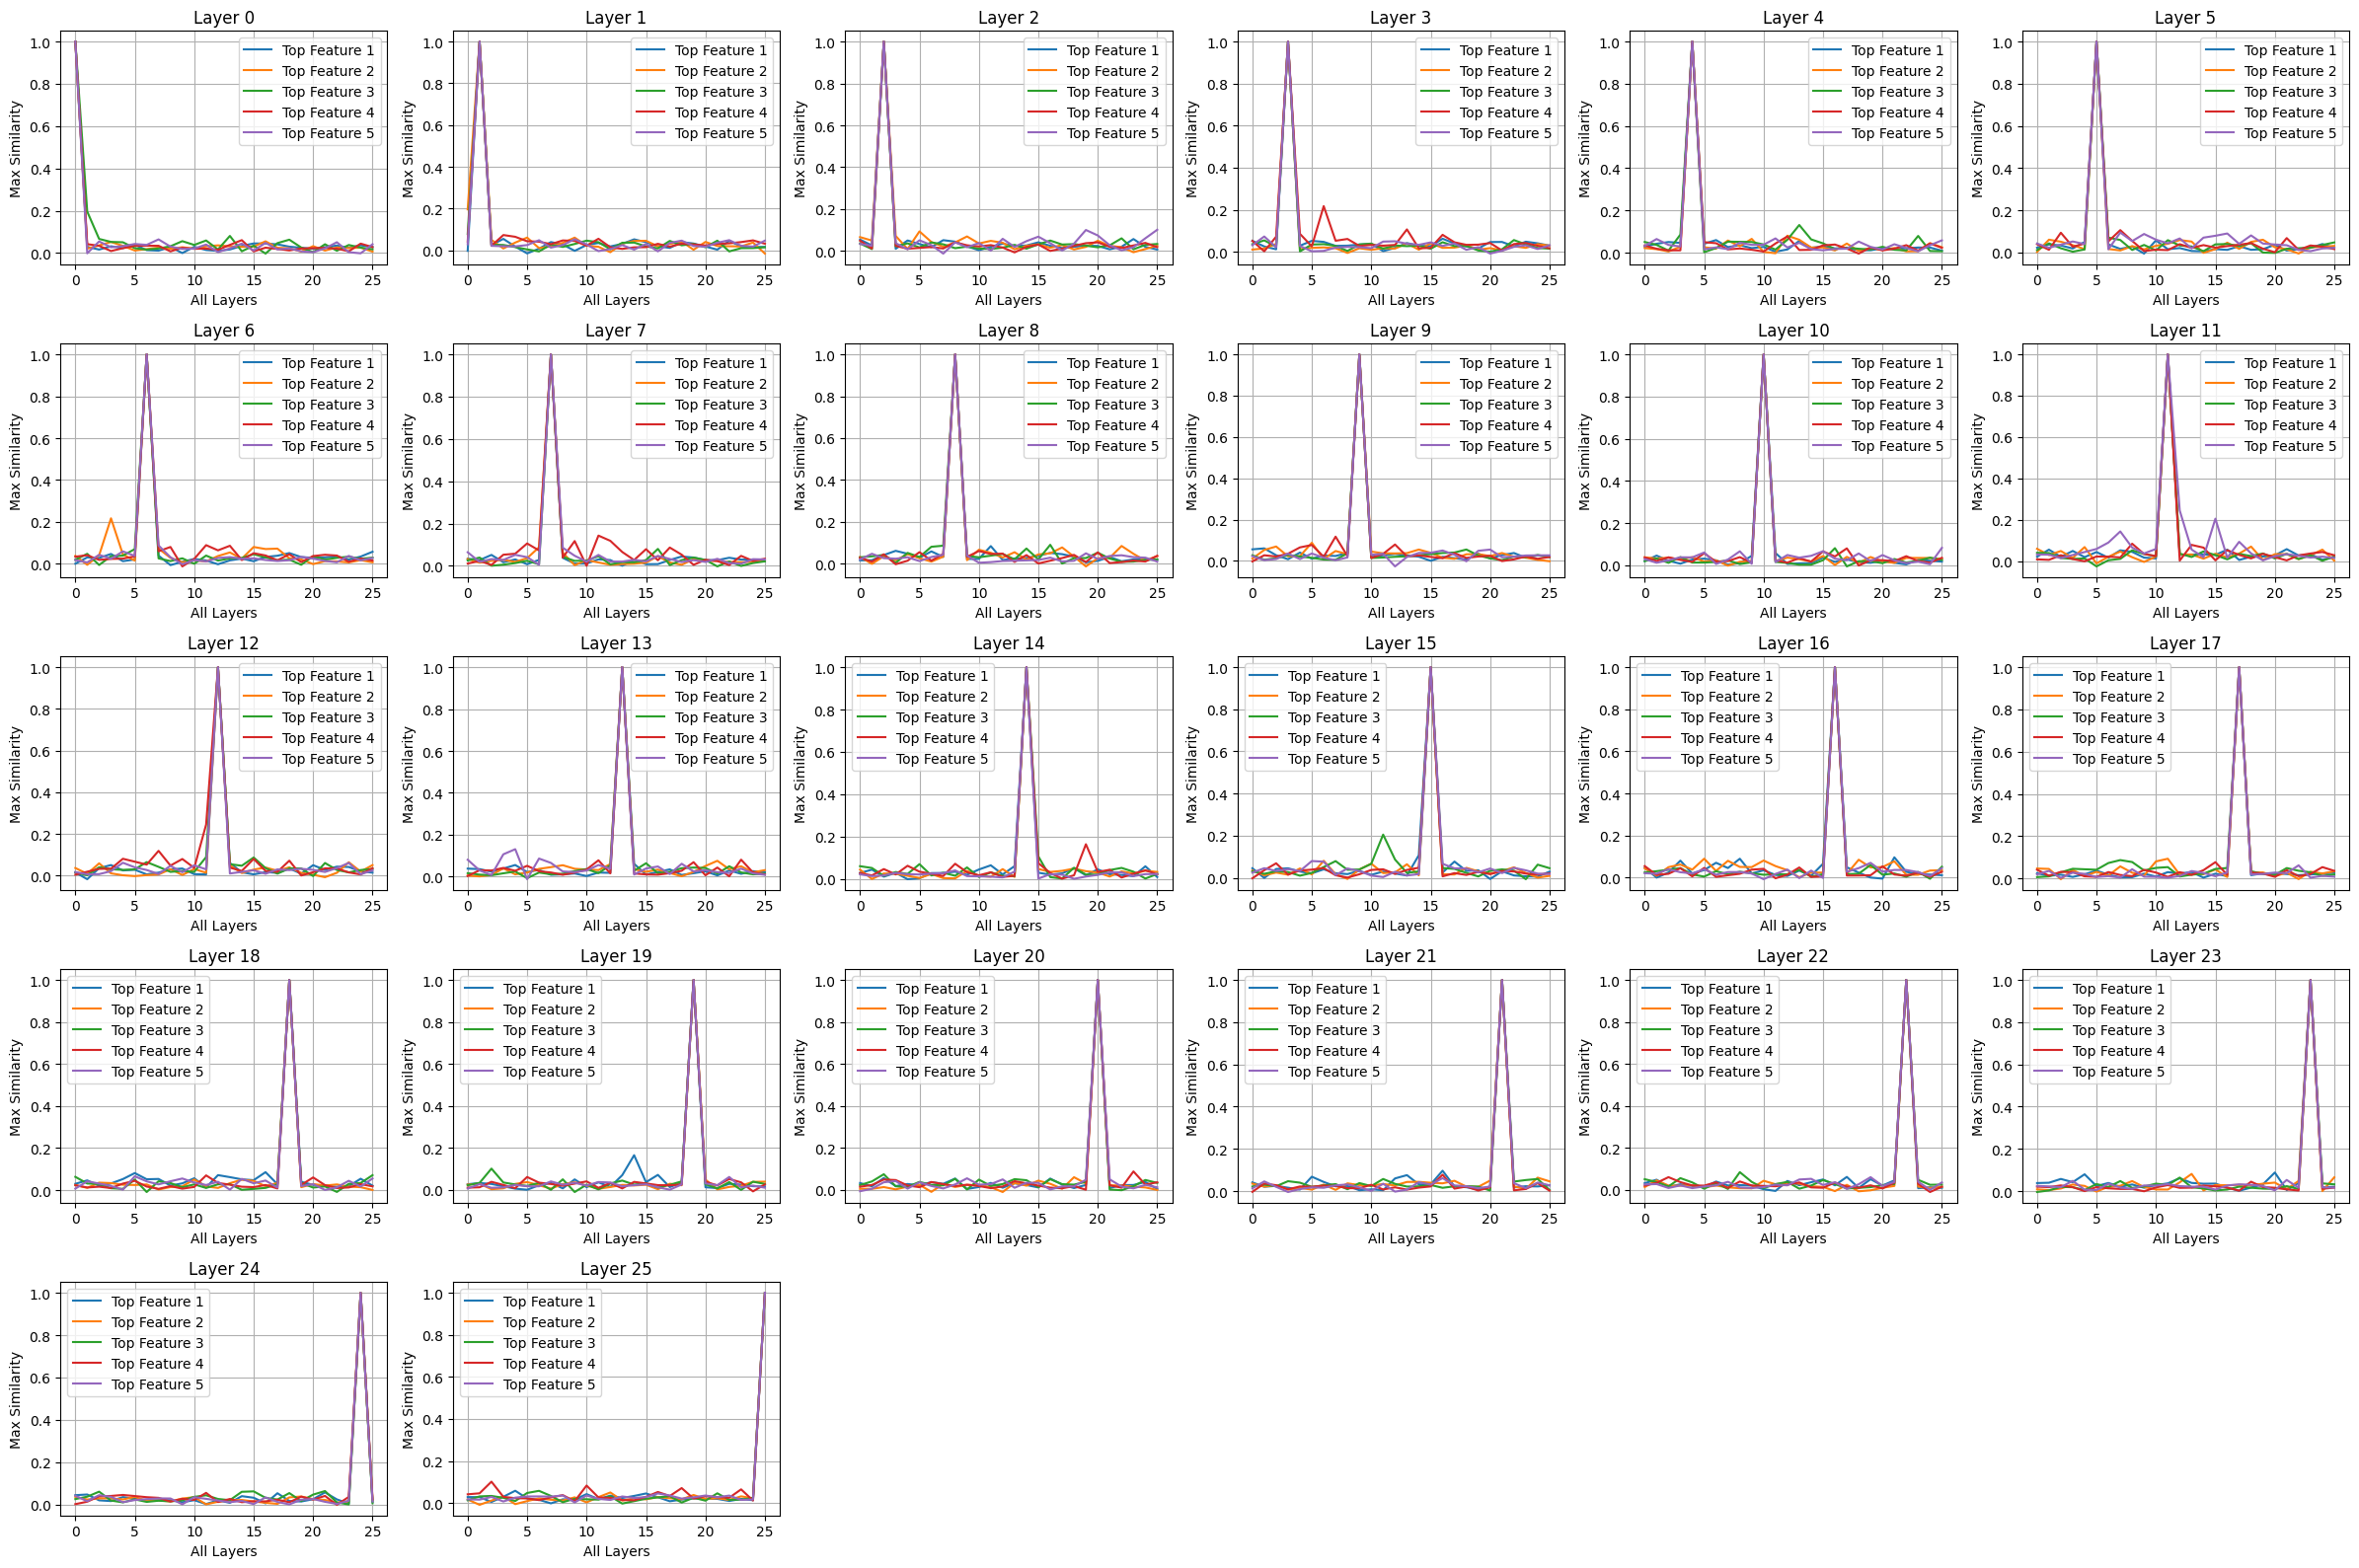

In [44]:
plot_top_features_similarity(max_anchor_similarities)

Creating visualizations for ADDITION anchors...


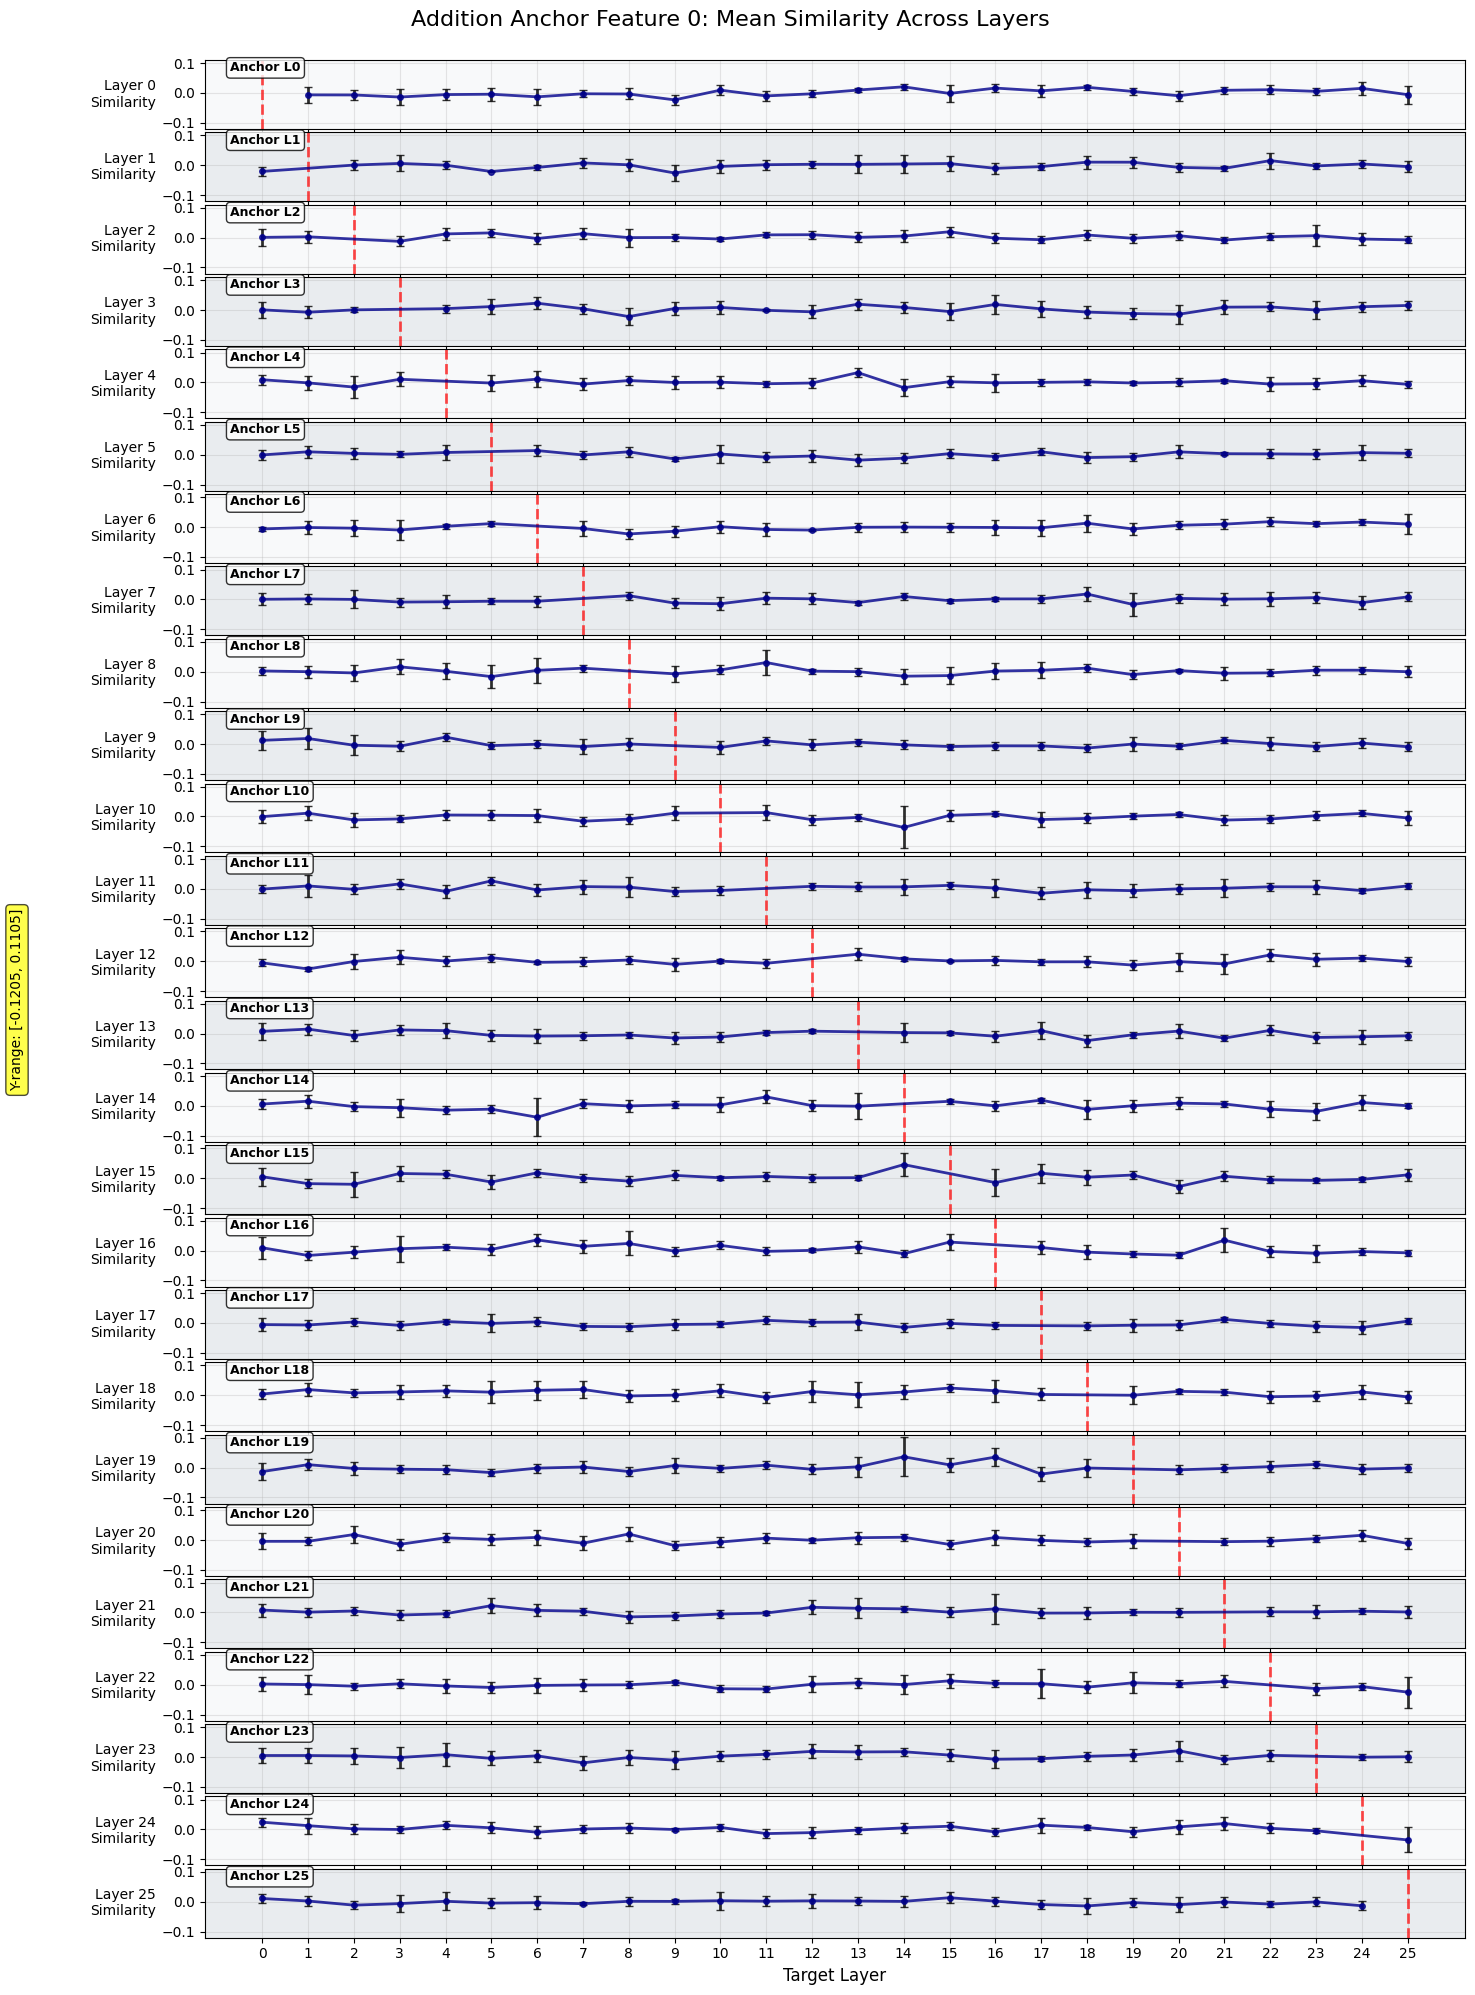

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3485062495.py:155: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_mean = plt.cm.get_cmap('RdYlBu_r').copy()
C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_20756\3485062495.py:165: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_std = plt.cm.get_cmap('Oranges').copy()


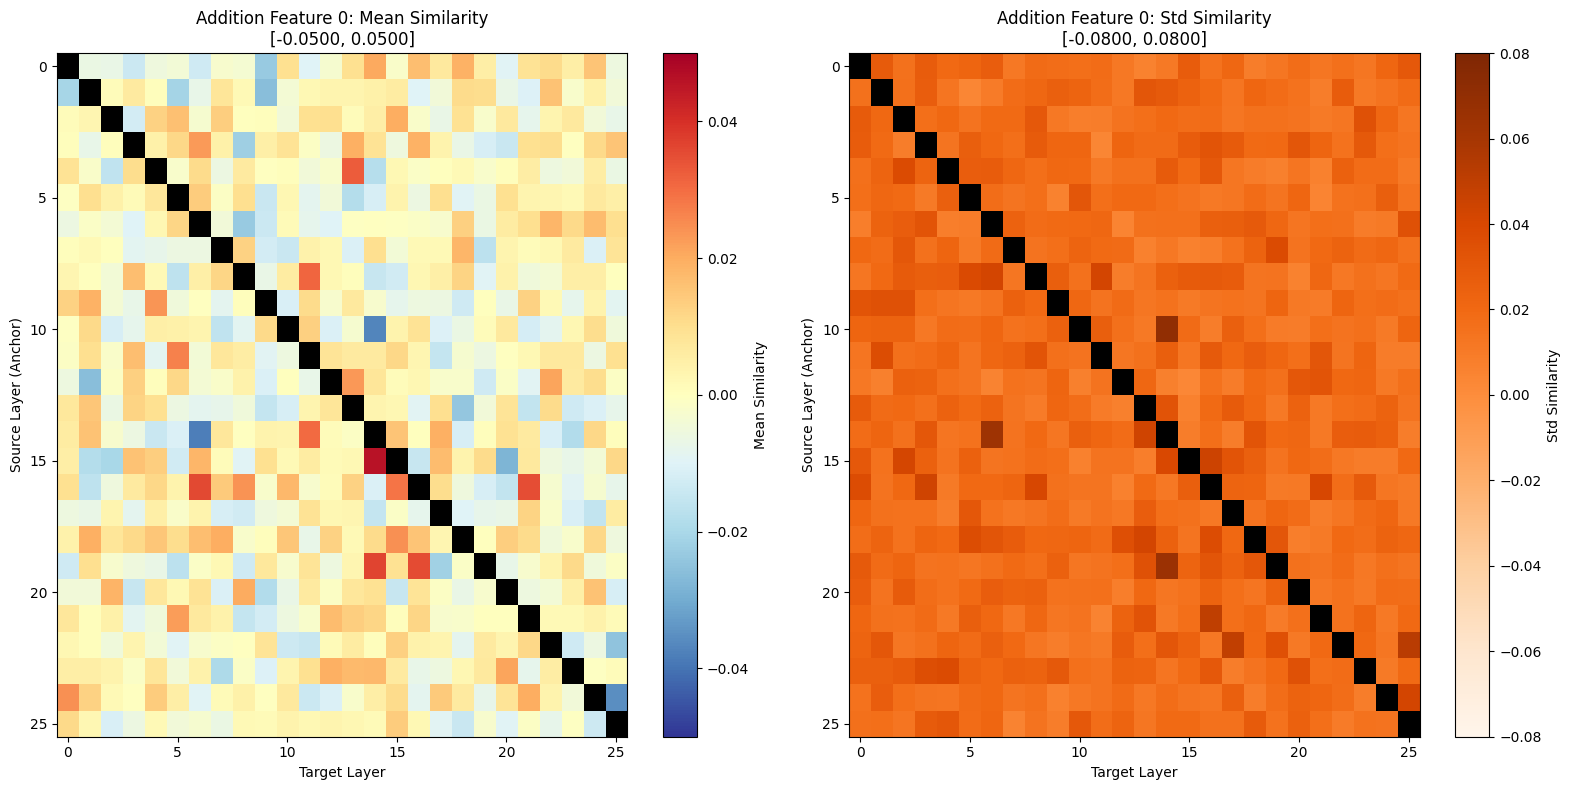

Creating visualizations for SUBTRACTION anchors...


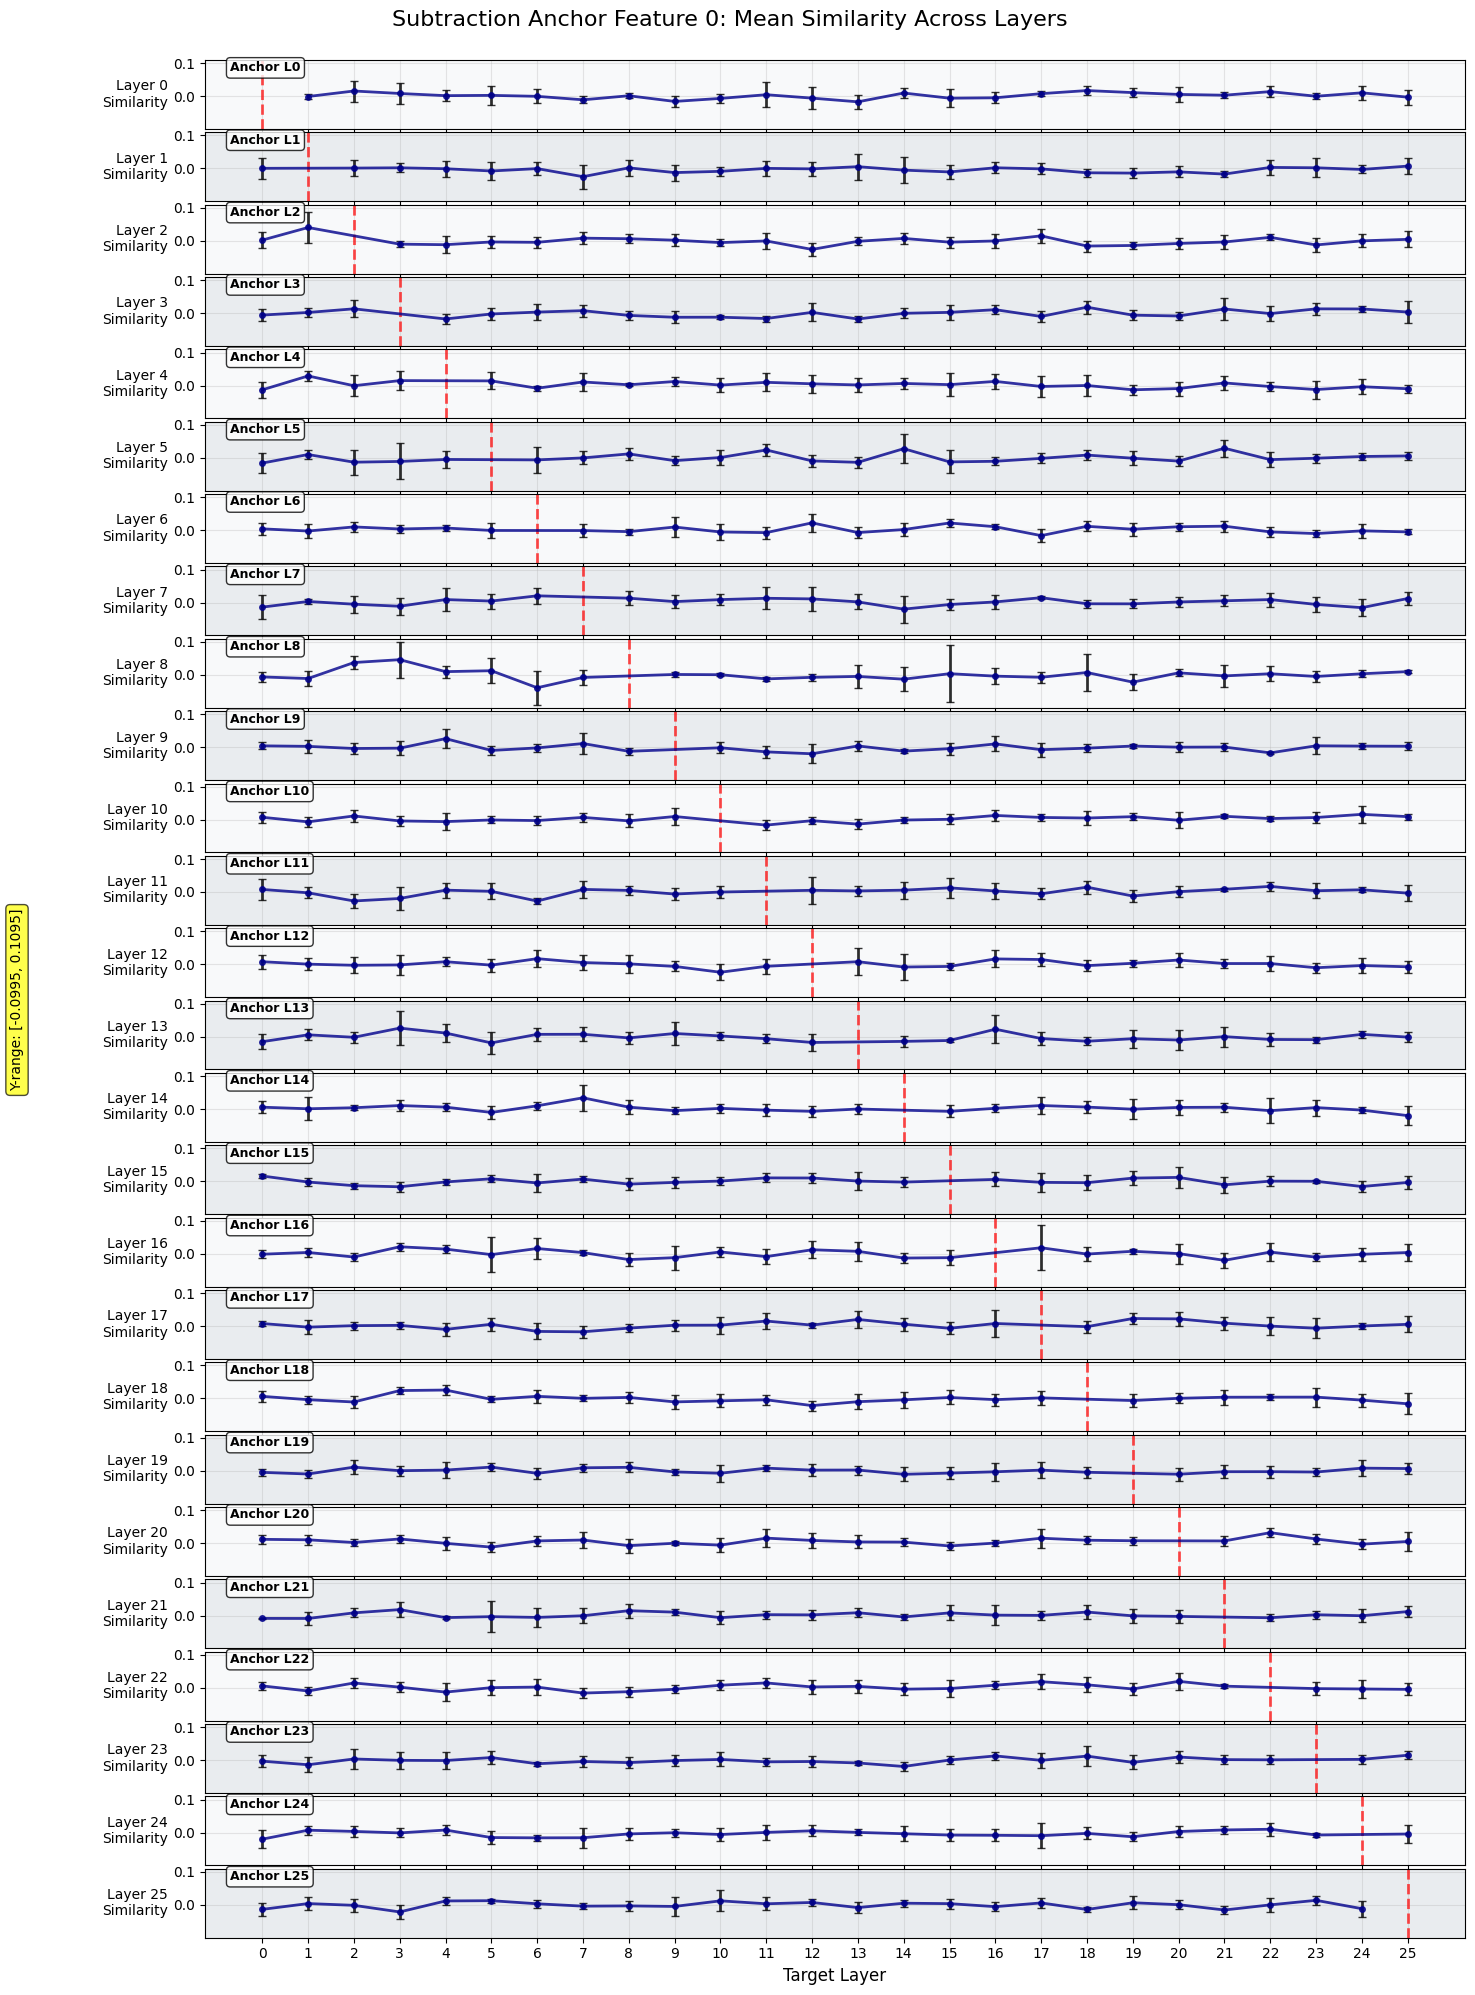

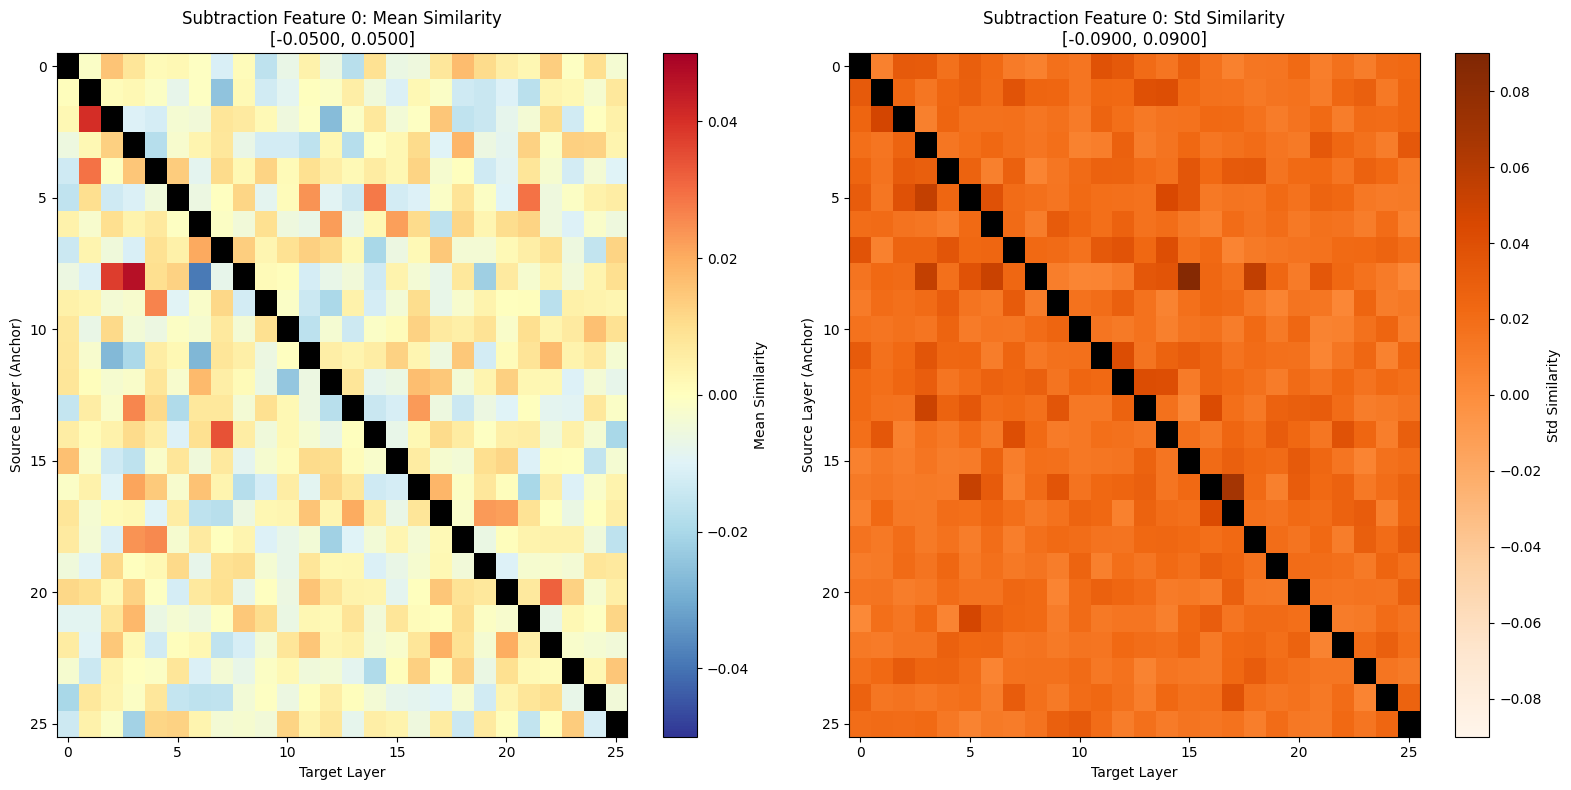

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

def calculate_mean_std_similarities(similarities):
    """
    Calculate mean and std similarities instead of min/max.
    
    Args:
        similarities: array of shape (24, 5, 24, 5)
    
    Returns:
        mean_similarities: array of shape (24, 5, 24) - mean across target features
        std_similarities: array of shape (24, 5, 24) - std across target features
    """
    mean_similarities = np.mean(similarities, axis=-1)  # shape: (24, 5, 24)
    std_similarities = np.std(similarities, axis=-1)    # shape: (24, 5, 24)
    
    return mean_similarities, std_similarities

def calculate_shared_ylim(mean_similarities, std_similarities, feature_idx=0, margin=0.05):
    """
    Calculate shared y-limits based on the data range with error bars.
    
    Args:
        mean_similarities: array of shape (24, 5, 24)
        std_similarities: array of shape (24, 5, 24)
        feature_idx: which feature to analyze
        margin: additional margin as fraction of range
    
    Returns:
        tuple: (y_min, y_max) for shared y-limits
    """
    # Get data for the specific feature, excluding diagonal
    mean_data = mean_similarities[:, feature_idx, :].copy()
    std_data = std_similarities[:, feature_idx, :].copy()
    np.fill_diagonal(mean_data, np.nan)
    np.fill_diagonal(std_data, np.nan)
    
    # Calculate range including error bars
    valid_mask = ~np.isnan(mean_data)
    if np.sum(valid_mask) == 0:
        return (0, 1)  # fallback
    
    lower_bounds = mean_data - std_data
    upper_bounds = mean_data + std_data
    
    y_min = np.around(np.nanmin(lower_bounds),2)
    y_max = np.around(np.nanmax(upper_bounds),2)
    
    # Add margin
    y_range = y_max - y_min
    margin_size = y_range * margin
    
    return (y_min - margin_size, y_max + margin_size)

def plot_anchor_similarity_grid(mean_similarities, std_similarities, 
                               feature_idx=0, title_prefix="Addition",
                               figsize=(15, 20)):
    """
    Create 24 subplots in a grid, one for each layer's anchor feature.
    Each subplot shows mean similarity with std error bars across all target layers.
    """
    # Calculate shared y-limits based on data
    y_min, y_max = calculate_shared_ylim(mean_similarities, std_similarities, feature_idx)
    
    fig, axes = plt.subplots(26, 1, figsize=figsize, sharex=True)
    fig.suptitle(f'{title_prefix} Anchor Feature {feature_idx}: Mean Similarity Across Layers', 
                 fontsize=16, y=0.995)
    
    # Color palette for alternating backgrounds
    colors = ['#f8f9fa', '#e9ecef']
    
    for layer in range(26):
        ax = axes[layer]
        
        # Get data for this layer's anchor
        means = mean_similarities[layer, feature_idx, :]
        stds = std_similarities[layer, feature_idx, :]
        
        # Set self-similarity to NaN (exclude from plot)
        means = means.copy()
        stds = stds.copy()
        means[layer] = np.nan
        stds[layer] = np.nan
        
        # Create x-axis (target layers)
        x = np.arange(26)
        
        # Plot with error bars
        valid_mask = ~np.isnan(means)
        ax.errorbar(x[valid_mask], means[valid_mask], yerr=stds[valid_mask], 
                   fmt='o-', capsize=3, capthick=1, linewidth=2, markersize=4,
                   color='darkblue', ecolor='black', alpha=0.8)
        
        # Highlight the source layer with a vertical line
        ax.axvline(x=layer, color='red', linestyle='--', alpha=0.7, linewidth=2)
        
        # Styling
        ax.set_ylabel(f'Layer {layer}\nSimilarity', fontsize=10, rotation=0, 
                     ha='right', va='center')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(y_min, y_max)  # Use data-driven limits
        
        # Alternate background colors
        ax.set_facecolor(colors[layer % 2])
        
        # Add layer number annotation
        ax.text(0.02, 0.98, f'Anchor L{layer}', transform=ax.transAxes, 
               fontsize=9, fontweight='bold', va='top',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        # Only show x-axis labels on bottom plot
        if layer < 23:
            ax.set_xticks([])
    
    # Bottom subplot gets x-axis labels
    axes[-1].set_xlabel('Target Layer', fontsize=12)
    axes[-1].set_xticks(range(26))
    
    # Add y-range information to the plot
    fig.text(0.02, 0.5, f'Y-range: [{y_min:.4f}, {y_max:.4f}]', 
             rotation=90, va='center', fontsize=10, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.97, hspace=0.05, left=0.15)
    plt.show()

def plot_mean_std_heatmaps(mean_similarities, std_similarities, 
                          feature_idx=0, title_prefix="Addition"):
    """
    Create side-by-side heatmaps for mean and std.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Prepare data (set diagonal to NaN)
    mean_data = mean_similarities[:, feature_idx, :].copy()
    std_data = std_similarities[:, feature_idx, :].copy()
    np.fill_diagonal(mean_data, np.nan)
    np.fill_diagonal(std_data, np.nan)
    
    # Calculate data-driven color limits
    # Find min and max, round down/up to 2 decimals
    mean_abs_max = max(abs(np.nanmin(mean_data)), abs(np.nanmax(mean_data)))
    mean_abs_max = np.ceil(mean_abs_max * 100) / 100
    mean_vmin, mean_vmax = -mean_abs_max, mean_abs_max

    std_abs_max = max(abs(np.nanmin(std_data)), abs(np.nanmax(std_data)))
    std_abs_max = np.ceil(std_abs_max * 100) / 100
    std_vmin, std_vmax = -std_abs_max, std_abs_max
    
    # Mean heatmap
    cmap_mean = plt.cm.get_cmap('RdYlBu_r').copy()
    cmap_mean.set_bad(color='black')
    
    im1 = ax1.imshow(mean_data, cmap=cmap_mean, aspect='auto', vmin=mean_vmin, vmax=mean_vmax)
    ax1.set_title(f'{title_prefix} Feature {feature_idx}: Mean Similarity\n[{mean_vmin:.4f}, {mean_vmax:.4f}]')
    ax1.set_xlabel('Target Layer')
    ax1.set_ylabel('Source Layer (Anchor)')
    plt.colorbar(im1, ax=ax1, label='Mean Similarity')
    
    # Std heatmap
    cmap_std = plt.cm.get_cmap('Oranges').copy()
    cmap_std.set_bad(color='black')
    
    im2 = ax2.imshow(std_data, cmap=cmap_std, aspect='auto', vmin=std_vmin, vmax=std_vmax)
    ax2.set_title(f'{title_prefix} Feature {feature_idx}: Std Similarity\n[{std_vmin:.4f}, {std_vmax:.4f}]')
    ax2.set_xlabel('Target Layer')
    ax2.set_ylabel('Source Layer (Anchor)')
    plt.colorbar(im2, ax=ax2, label='Std Similarity')
    
    plt.tight_layout()
    plt.show()


# Main usage function
def visualize_mean_std_similarities(addition_similarities, subtraction_similarities):
    """
    Complete visualization pipeline for mean and std similarities.
    """
    # Calculate mean and std
    add_mean, add_std = calculate_mean_std_similarities(addition_similarities)
    sub_mean, sub_std = calculate_mean_std_similarities(subtraction_similarities)
    
    print("Creating visualizations for ADDITION anchors...")
    
    # Your requested visualization: 24 line plots
    plot_anchor_similarity_grid(add_mean, add_std, feature_idx=0, 
                               title_prefix="Addition")
    
    # Additional intuitive visualizations
    plot_mean_std_heatmaps(add_mean, add_std, feature_idx=0, 
                          title_prefix="Addition")
    
    print("Creating visualizations for SUBTRACTION anchors...")
    
    # Same for subtraction
    plot_anchor_similarity_grid(sub_mean, sub_std, feature_idx=0, 
                               title_prefix="Subtraction")
    plot_mean_std_heatmaps(sub_mean, sub_std, feature_idx=0,
                          title_prefix="Subtraction")

# Usage:
add_mean, add_std = calculate_mean_std_similarities(addition_similarities)
sub_mean, sub_std = calculate_mean_std_similarities(subtraction_similarities)
visualize_mean_std_similarities(addition_similarities, subtraction_similarities)

# MISC 

## inset plots

In [46]:
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# def plot_activation_frequencies_by_stage_with_insets(addition_freq, subtraction_freq):
#     stages = {
#         'Early (0-7)': (0, 8),
#         'Middle (8-15)': (8, 16),
#         'Late (16-23)': (16, 24)
#     }
#     fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
#     for ax, (stage, (start, end)) in zip(axes, stages.items()):
#         num_layers = end - start
#         colors = cm.Greys(np.linspace(0.3, 0.95, num_layers))
#         for i, layer in enumerate(range(start, end)):
#             ax.scatter(
#                 addition_freq[layer], subtraction_freq[layer],
#                 color=colors[i], label=f'Layer {layer}', alpha=0.6, s=8
#             )
#         ax.set_title(stage)
#         ax.set_xlabel('Addition Activation Frequency')
#         if ax is axes[0]:
#             ax.set_ylabel('Subtraction Activation Frequency')
#         ax.grid(True)
#         # Only show legend for the last subplot to avoid clutter
#         if ax is axes[-1]:
#             ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)

#         # Inset for X > 0.7, Y < 0.2 (top right)
#         axins1 = inset_axes(ax, width="30%", height="30%", loc='upper right', borderpad=1)
#         for i, layer in enumerate(range(start, end)):
#             mask = (addition_freq[layer] > 0.7) & (subtraction_freq[layer] < 0.2)
#             axins1.scatter(addition_freq[layer][mask], subtraction_freq[layer][mask], 
#                            color=colors[i], alpha=0.7, s=8)
#         axins1.set_xlim(0.7, 1.0)
#         axins1.set_ylim(0.0, 0.2)
#         axins1.set_xticks([])
#         axins1.set_yticks([])
#         axins1.set_title('X>0.7, Y<0.2', fontsize=8)

#         # Inset for X < 0.2, Y > 0.7 (bottom left)
#         axins2 = inset_axes(ax, width="30%", height="30%", loc='lower left', borderpad=1)
#         for i, layer in enumerate(range(start, end)):
#             mask = (addition_freq[layer] < 0.2) & (subtraction_freq[layer] > 0.7)
#             axins2.scatter(addition_freq[layer][mask], subtraction_freq[layer][mask], 
#                            color=colors[i], alpha=0.7, s=8)
#         axins2.set_xlim(0.0, 0.2)
#         axins2.set_ylim(0.7, 1.0)
#         axins2.set_xticks([])
#         axins2.set_yticks([])
#         axins2.set_title('X<0.2, Y>0.7', fontsize=8)

#     plt.tight_layout()
#     plt.show()

# plot_activation_frequencies_by_stage_with_insets(addition_freq, subtraction_freq)